In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir

Load the JSON files 

In [593]:
# Load json files 
json_data_asctb = {}
for filename in listdir('./asct+b/'):
    if '.json' in filename:
        # print(filename)
        with open(f'./asct+b/{filename}', encoding='utf8') as json_file:
            data = json.load(json_file)

        json_data_asctb[filename[:-5]] = data

Order of the organs

In [598]:
griffin_organ_order = ['lung', 'heart', 'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 
                       'liver', 'pancreas', 'small_intestine', 'large_intestine', 'kidney', 
                       'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube', 
                       'uterus', 'knee', 'bone_marrow']

In [600]:
json_data_asctb = {organ: json_data_asctb[organ] for organ in griffin_organ_order}

In [601]:
json_data_asctb.keys()

dict_keys(['lung', 'heart', 'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 'liver', 'pancreas', 'small_intestine', 'large_intestine', 'kidney', 'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube', 'uterus', 'knee', 'bone_marrow'])

In [7]:
json_data_asctb['skin']['nodes'][0]

{'id': 0,
 'type': 'AS',
 'name': 'Body',
 'metadata': {'name': 'Body',
  'ontologyId': 'UBERON:0013702',
  'ontologyType': 'UBERON',
  'ontologyTypeId': '0013702',
  'label': 'body proper',
  'references': [{'id': 'PMID: 8689554.',
    'doi': 'DOI: 10.1146/annurev.cb.11.110195.001011',
    'notes': 'Fuchs E. Keratins and the skin. Annu Rev Cell Dev Biol. 1995;11:123-53.'},
   {'id': 'PMID: 8752847',
    'doi': 'DOI: 10.1111/1523-1747.ep12298323',
    'notes': 'Robinson NA, LaCelle PT, Eckert RL. Involucrin is a covalently crosslinked constituent of highly purified epidermal corneocytes: evidence for a common pattern of involucrin crosslinking in vivo and in vitro. J Invest Dermatol. 1996 Jul;107(1):101-7.'},
   {'id': 'PMID: 2248957',
    'doi': 'DOI: 10.1021/bi00492a018',
    'notes': 'Gan SQ, McBride OW, Idler WW, Markova N, Steinert PM. Organization, structure, and polymorphisms of the human profilaggrin gene. Biochemistry. 1990 Oct 9;29(40):9432-40. DOI: 10.1021/bi00492a018. Errat

In [591]:
def combine_data(json_dat, remove_ctct=True, combine=True, correct=False, blood=False):
    nodes_data = []
    edges_data = []
    organ_names = ['body']
    
    
    node_id_start_point = 1 
    
    #add body:
    body_df = pd.DataFrame(json_dat['brain']['nodes']).head(1)
    body_df.index = body_df['id']
    body_df['id_old'] = 0
    body_df['organ'] = 'body'
    body_df['ontology_id'] = 'UBERON:0013702'
    
    nodes_data += [body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]]
    if not combine:
        body_data = body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']].copy()
    
    if blood:
        exclude = ['blood_pelvis', 'lymph_vasculature', 'peripheral_nervous_system']
    else:
        exclude = ['blood_pelvis', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']
    
    for name in json_dat.keys():
        if name in exclude:
            continue
        else:
            # print(name)
            organ_names += [name]
            # Combine nodes:
            organ_nodes = pd.DataFrame(json_dat[name]['nodes']).iloc[1:,:]
            not_as_ct_nodes = organ_nodes[~organ_nodes['type'].isin(['AS', 'CT'])]['id']
            organ_nodes['id_old'] = organ_nodes['id'].copy()
            if combine:
                organ_nodes['id'] = organ_nodes['id'].add(node_id_start_point-1)
            organ_nodes.index = organ_nodes['id']
            # organ_nodes = organ_nodes.drop(columns=['id'])
            organ_nodes = organ_nodes[organ_nodes['type'].isin(['AS', 'CT'])]
            organ_nodes['organ'] = name
            organ_nodes['ontology_id'] = organ_nodes['metadata'].apply(lambda x: x['ontologyId'])
            organ_nodes = organ_nodes[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]
            

            # Combine edges:
            organ_edges = pd.DataFrame(json_dat[name]['edges'])
            ## Remove CT-CT edges:
            if remove_ctct:
                organ_nodes_original = pd.DataFrame(json_dat[name]['nodes'])
                organ_nodes_original.index = organ_nodes_original['id']
                organ_edges['source_type'] = organ_edges['source'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges['target_type'] = organ_edges['target'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges = organ_edges[(organ_edges['source_type']=='AS')|(organ_edges['target_type']=='AS')]
            ##rename edges due to colliding ids
            organ_network = nx.from_pandas_edgelist(organ_edges)
            #remove unnecessary edges:
            organ_network.remove_nodes_from(not_as_ct_nodes.to_list())
            #remove body-organ edge (we will ad it later)
            organ_network.remove_edge(0, 1)
            organ_network.remove_node(0)
            #rename nodes
            # organ_network = nx.relabel_nodes(organ_network, organ_nodes['name'].to_dict())
            if combine:
                organ_network = nx.convert_node_labels_to_integers(organ_network, first_label=node_id_start_point)
            #add body-organ edge
            # organ_network.add_node(0) 
            # nx.set_node_attributes(organ_network, {0: {"type": 'AS', "name": "Body", 'organ': 'body', 'ontology_id': 'UBERON:0013702'}})
            if combine:
                organ_network.add_edge(node_id_start_point, 0)
                if correct:
                    if name=='fallopian_tube':
                        organ_nodes = organ_nodes[organ_nodes['name']!='wall of uterine tube']
                    elif name=='lung':
                        organ_network.add_edge(34+node_id_start_point-1, node_id_start_point) 
                else:
                    if name=='fallopian_tube':
                        organ_network.add_edge(72+node_id_start_point-1, 0)                
                    elif name=='lung':
                        organ_network.add_edge(34+node_id_start_point-1, 0) 
                    
            else:
                organ_network.add_edge(0, 1)
                if name=='fallopian_tube':
                    organ_network.add_edge(0, 72)
                elif name=='lung':
                    organ_network.add_edge(0, 34)
                

            # Create CT duplicates
            organ_CT_nodes = organ_nodes[organ_nodes['type']=='CT'].copy()
            organ_CT_nodes['degree'] = dict(organ_network.degree(organ_CT_nodes['id'])).values()
            
            ct_nodes_to_copy = organ_CT_nodes[organ_CT_nodes['degree']>1]['id'].values
            edges_to_remove = []
            edges_to_add = []
            
            for ct_node in ct_nodes_to_copy:
                as_neighbors_of_ct = list(nx.neighbors(organ_network, ct_node))
                for ind, as_neighbor in enumerate(as_neighbors_of_ct):
                    if ind==0:
                        continue
                    else:
                        ct_node_details = organ_nodes.loc[ct_node].to_dict()
                        new_node_id = organ_nodes['id'].max()+1
                        ct_node_details['id'] = new_node_id
                        # organ_nodes = organ_nodes.append(ct_node_details, ignore_index=False)
                        organ_nodes.loc[new_node_id] = ct_node_details
                        
                        edges_to_remove += [(as_neighbor, ct_node)]
                        edges_to_add += [(as_neighbor, new_node_id)]
                        
            organ_network.remove_edges_from(edges_to_remove)
            organ_network.add_edges_from(edges_to_add)
                
            
            
            nodes_data += [organ_nodes]
            if not combine:
                nodes_data[-1] = pd.concat([body_data, nodes_data[-1]])
            
            node_id_start_point = max(organ_network.nodes)+1
            
            organ_edges = nx.to_pandas_edgelist(organ_network)[['source', 'target']]
            print(f"{name} is tree: {nx.is_tree(organ_network)}")
            edges_data += [organ_edges]

    if combine:
        # Renumbering the main organs (1st level) so in the visualization they are in the right order
        # nodes = pd.concat(nodes_data, ignore_index=True)
        # edge_mapping = dict([(nodes[nodes.name==organ_name_dict[organ_name]]['id'].values[0], sequence[organ_name]) for organ_name in sequence.keys()])
        # organ_node_idx = dict([(organ_name, nodes[nodes.name==organ_name_dict[organ_name]].index[0]) for organ_name in sequence.keys()])
        # for organ_name in sequence.keys():
        #     nodes.at[organ_node_idx[organ_name], 'id'] = sequence[organ_name]
        # edges = pd.concat(edges_data, ignore_index=True)
        # body_network = nx.relabel_nodes(nx.from_pandas_edgelist(edges), edge_mapping)
        # return nodes, nx.to_pandas_edgelist(body_network)
        return pd.concat(nodes_data, ignore_index=True), pd.concat(edges_data, ignore_index=True)
    else:
        return dict(zip(organ_names, nodes_data)), dict(zip(organ_names[1:], edges_data))

Combine the nodes and edges of the organs. (The code checks whether the graph of the organs are trees)

In [9]:
nodes, edges = combine_data(json_data_asctb, remove_ctct=True, combine=True)

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
ovary is tree: True
fallopian_tube is tree: True
uterus is tree: True
knee is tree: True
bone_marrow is tree: True


In [12]:
nodes.head()

,id,id_old,name,type,organ,ontology_id
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,Respiratory System,AS,lung,UBERON:0001004
2,2,2,Trachea,AS,lung,UBERON:0003126
3,3,3,tracheal epithelium,AS,lung,UBERON:0001901
4,4,4,tracheal smooth muscle,AS,lung,UBERON:0003387


In [13]:
edges.head()

,source,target
0,1,2
1,1,21
2,1,47
3,1,72
4,1,126


__Corrected version__ <br>
(there are some mistakes in v1.1 that will be corrected in the next release but here we corrected these manually: lung vasculature is connected to the lung instead of the body, and the 'wall of uterine tube' is removed)

In [10]:
nodes_c, edges_c = combine_data(json_data_asctb, remove_ctct=True, combine=True, correct=True)

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
ovary is tree: True
fallopian_tube is tree: False
uterus is tree: True
knee is tree: True
bone_marrow is tree: True


## Construction of network 

In [14]:
whole_graph = nx.from_pandas_edgelist(edges_c)

In [15]:
def get_parent(node, graph):
    neighbors = nx.neighbors(graph, node)
    # print(len([x for x in neighbors if x<node]))
    return min(nx.neighbors(graph, node))

In [16]:
nodes_c['parent']= nodes_c['id'].apply(get_parent, graph=whole_graph)

In [17]:
nodes_c

,id,id_old,name,type,organ,ontology_id,parent
0,0,0,Body,AS,body,UBERON:0013702,1
1,1,1,Respiratory System,AS,lung,UBERON:0001004,0
2,2,2,Trachea,AS,lung,UBERON:0003126,1
3,3,3,tracheal epithelium,AS,lung,UBERON:0001901,2
4,4,4,tracheal smooth muscle,AS,lung,UBERON:0003387,2
...,...,...,...,...,...,...,...
3518,3519,44,mature CD8 T cell,CT,bone_marrow,,3476
3519,3520,45,NK lymphocytes,CT,bone_marrow,CL:0000814,3476
3520,3521,46,CD56 bright Natural Killer,CT,bone_marrow,CL:0000938,3476
3521,3522,47,mature Natural killer,CT,bone_marrow,CL:0000824,3476


In [23]:
nodes_c['color'] = nodes_c['type'].apply(lambda x: '#984ea' if x=='AS' else '#ff7f00')

In [24]:
# nodes['size']=10

In [25]:
nodes_json = nodes_c[['id', 'name', 'parent', 'type', 'ontology_id', 'color']].to_dict(orient='index')

In [26]:
del(nodes_json[0]['parent'])

In [27]:
nodes_json = [nodes_json[i] for i in nodes_json.keys()]

In [28]:
with open('human_atlas_c', 'w', encoding='utf8') as f:
    f.write('[\n')
    for item in nodes_json:
        f.write(f"{json.dumps(item)},\n".replace("'", ''))
    f.write(']')

### Female network 

In [212]:
def construct_network(jason_data, filename, correct=False):
    nodes_df, edges_df = combine_data(jason_data, remove_ctct=True, combine=True, correct=correct)
    graph = nx.from_pandas_edgelist(edges_df)
    nodes_df['parent']= nodes_df['id'].apply(get_parent, graph=graph)
    nodes_df['color'] = nodes_df['type'].apply(lambda x: '#984ea3' if x=='AS' else '#ff7f00')
    
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 'color', 'organ']].to_dict(orient='index')
    del(nodes_json[0]['parent'])
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    with open(f'{filename}.json', 'w', encoding='utf8') as f:
        f.write('[\n')
        for item in nodes_json:
            f.write(f"{json.dumps(item)},\n".replace("'", ''))
        f.write(']')
    
    return nodes_df, edges_df

In [213]:
# fem_json_data = {organ: json_data_asctb[organ] for organ in reversed(griffin_organ_order)}

In [1095]:
fem_json_data = {organ: json_data_asctb[organ] for organ in griffin_organ_order}

In [1096]:
del(fem_json_data['prostate'])

In [1097]:
fem_nodes, fem_edges = construct_network(fem_json_data, 'human_atlas_female')

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
ovary is tree: True
fallopian_tube is tree: True
uterus is tree: True
knee is tree: True
bone_marrow is tree: True


In [1098]:
fem_nodes_c, fem_edges_c = construct_network(fem_json_data, 'human_atlas_female_c', correct=True)

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
ovary is tree: True
fallopian_tube is tree: False
uterus is tree: True
knee is tree: True
bone_marrow is tree: True


### Male network 

In [1072]:
male_json_data = json_data_asctb.copy()

In [1073]:
del(male_json_data['fallopian_tube'])

In [1074]:
del(male_json_data['ovary'])

In [1075]:
del(male_json_data['uterus'])

In [1076]:
male_nodes, male_edges = construct_network(male_json_data, 'human_atlas_male')

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
knee is tree: True
bone_marrow is tree: True


In [1077]:
male_nodes_c, male_edges_c = construct_network(male_json_data, 'human_atlas_male_c', correct=True)

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
knee is tree: True
bone_marrow is tree: True


# Vasculature 

In [223]:
vasc_data = pd.read_excel('./Blood_Vasculature_v1.2_EXTENDED.xlsx', sheet_name='BodyPartVessel')
vasc_data

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU
0,abdominal cavity,UBERON:0003684,abdominal aorta,abdominal aorta,UBERON:0001516,artery,NaN,NaN,NaN
1,abdominal cavity,UBERON:0003684,celiac artery,celiac artery,UBERON:0001640,artery,NaN,NaN,NaN
2,abdominal cavity,UBERON:0003684,inferior mesenteric artery,inferior mesenteric artery,UBERON:0001183,artery,NaN,NaN,NaN
3,abdominal cavity,UBERON:0003684,inferior mesenteric vein,inferior mesenteric vein,UBERON:0001215,vein,NaN,hepatic portal system,NaN
4,abdominal cavity,UBERON:0003684,superior mesenteric artery,superior mesenteric artery,UBERON:0001182,artery,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
956,vagina,UBERON:0000996,pterygovaginal artery,NaN,NaN,artery,NaN,NaN,NaN
957,vagina,UBERON:0000996,vaginal artery,Vaginal artery,FMA:18832,artery,NaN,NaN,NaN
958,vagina,UBERON:0000996,vaginal vein,vaginal vein,UBERON:0001319,vein,NaN,NaN,NaN
959,vagina,UBERON:0000996,vesical plexus,Vesical nerve plexus,FMA:6646,vein,NaN,NaN,NaN


Organs in the ASCT+B tables:

In [53]:
nodes['organ'].unique()

array(['body', 'lung', 'heart', 'brain', 'eye', 'skin', 'thymus',
       'lymph_nodes', 'spleen', 'liver', 'pancreas', 'small_intestine',
       'large_intestine', 'kidney', 'urinary_bladder', 'ureter',
       'prostate', 'ovary', 'fallopian_tube', 'uterus', 'knee',
       'bone_marrow'], dtype=object)

Organs/body parts in the vasculature data:

In [54]:
vasc_data['BodyPart'].unique()

array(['abdominal cavity', 'abdominal cavity;thoracic cavity',
       'abdominal wall', 'adrenal gland', 'arm', 'brain', 'brainstem',
       'cerebellum', 'clitoris', 'diaphragm', 'ear', 'esophagus', 'eye',
       'face', 'foot', 'hand', 'head', 'heart', 'heart chamber', 'kidney',
       'large intestine', 'larynx', 'leg', 'liver', 'lung', 'neck',
       'nose', 'ovary', 'pancreas', 'pancreas;small intestine', 'pelvis',
       'penis', 'pituitary gland', 'rectum', 'scrotum', 'shoulder',
       'small intestine', 'spinal cord', 'spleen', 'stomach',
       'stomach;small intestine', 'testis', 'thoracic cavity',
       'thoracic wall', 'thymus', 'thyroid gland', 'urinary bladder',
       'uterus', 'vagina'], dtype=object)

Matching body parts based on uberon id (BodyPartID)

In [55]:
nodes[nodes.ontology_id.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))]

,id,id_old,name,type,organ,ontology_id
905,905,905,Lung,AS,lung,UBERON:0002048
1019,1019,1,heart,AS,heart,UBERON:0000948
1200,1200,1,brain,AS,brain,UBERON:0000955
1360,1360,161,cerebellum,AS,brain,UBERON:0002037
1510,1510,1,eye,AS,eye,UBERON:0000970
1665,1665,1,thoracic thymus,AS,thymus,UBERON:0002370
1882,1882,1,spleen,AS,spleen,UBERON:0002106
2053,2053,1,liver,AS,liver,UBERON:0002107
2101,2101,1,Pancreas,AS,pancreas,UBERON:0001264
2307,2307,1,Small Intestine,AS,small_intestine,UBERON:0002108


In [56]:
vasc_data[vasc_data.BodyPartID.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))].BodyPart.unique()

array(['brain', 'cerebellum', 'eye', 'heart', 'kidney', 'large intestine',
       'liver', 'lung', 'ovary', 'pancreas', 'rectum', 'small intestine',
       'spleen', 'thymus', 'urinary bladder', 'uterus'], dtype=object)

The set of uberon IDs that are in the ASCT+B tables:

In [57]:
ids_in_organtables = set(nodes.ontology_id)

Get the mathching and non-matching vessels:

In [58]:
vasc_data['is_in_organ_table'] = vasc_data['VesselID'].apply(lambda x: 1 if x in ids_in_organtables else 0)
vasc_data['not_in_organ_table'] = vasc_data['VesselID'].apply(lambda x: 0 if x in ids_in_organtables else 1)
vasc_data['#vessels'] = 1

In [59]:
vasc_data[vasc_data['is_in_organ_table']==1]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
154,eye,UBERON:0000970,capillary layer of choroid,capillary layer of choroid,UBERON:0005336,capillary,fenestrated,NaN,NaN,1,0,1
336,heart,UBERON:0000948,atrioventicular nodal artery,Atrioventricular node branch of right coronary...,FMA:3851,artery,NaN,NaN,NaN,1,0,1
337,heart,UBERON:0000948,conus artery,Conus artery,FMA:15736,artery,NaN,NaN,NaN,1,0,1
338,heart,UBERON:0000948,coronary sinus,coronary sinus,UBERON:0005438,sinus,NaN,NaN,NaN,1,0,1
339,heart,UBERON:0000948,diagonal branch of left anterior descending ar...,Diagonal branch of anterior descending branch ...,FMA:3860,artery,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
934,thyroid gland,UBERON:0002046,inferior thyroid vein,inferior thyroid vein,UBERON:0007156,vein,NaN,NaN,NaN,1,0,1
946,uterus,UBERON:0000995,arcuate artery of uterus,helicine branch of uterine artery,UBERON:0015173,artery,NaN,NaN,NaN,1,0,1
947,uterus,UBERON:0000995,artery of round ligament of uterus,Artery of round ligament of uterus,FMA:70195,artery,NaN,NaN,NaN,1,0,1
949,uterus,UBERON:0000995,uterine artery,uterine artery,UBERON:0002493,artery,NaN,NaN,NaN,1,0,1


## Circles/bubbles

In [60]:
data_for_circles = (vasc_data[vasc_data.BodyPartID.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))][['BodyPart', 'BodyPartID', 
                                                                                                                                'is_in_organ_table', 
                                                                                                                                'not_in_organ_table', 
                                                                                                                                '#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
data_for_circles.reset_index()

,BodyPart,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
0,brain,UBERON:0000955,0,66,66
1,cerebellum,UBERON:0002037,0,6,6
2,eye,UBERON:0000970,1,20,21
3,heart,UBERON:0000948,13,8,21
4,kidney,UBERON:0002113,3,23,26
5,large intestine,UBERON:0000059,0,35,35
6,liver,UBERON:0002107,2,54,56
7,lung,UBERON:0002048,31,13,44
8,ovary,UBERON:0000992,1,4,5
9,pancreas,UBERON:0001264,0,25,25


In [61]:
rest = (vasc_data[~vasc_data.BodyPartID.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))][['BodyPart', 'BodyPartID', 
                                                                                                                      'is_in_organ_table', 'not_in_organ_table', '#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
rest

,,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,BodyPartID,,,
abdominal cavity,UBERON:0003684,0,6,6
abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,0,2,2
abdominal wall,UBERON:0003697,0,7,7
adrenal gland,UBERON:0002369,0,7,7
arm,UBERON:0001460,0,25,25
brainstem,UBERON:0002298,0,2,2
clitoris,UBERON:0002411,0,2,2
diaphragm,UBERON:0001103,0,13,13
ear,UBERON:0001690,0,12,12


The four matching vessels from heart chamber are added to heart, and the 2 thyroid gland vessels are added to lung manually. The one matching vessel in testis is matching with a vessel in  the ovary, so I didn't add it to that. 

### The query of these vessels can be seen below:

Vessels in the heart chamber:

In [62]:
vasc_data[vasc_data.BodyPartID=="UBERON:0004151"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
357,heart chamber,UBERON:0004151,left atrium,left cardiac atrium,UBERON:0002079,heart chamber,NaN,NaN,NaN,1,0,1
358,heart chamber,UBERON:0004151,left ventricle,heart left ventricle,UBERON:0002084,heart chamber,NaN,NaN,NaN,1,0,1
359,heart chamber,UBERON:0004151,right atrium,right cardiac atrium,UBERON:0002078,heart chamber,NaN,NaN,NaN,1,0,1
360,heart chamber,UBERON:0004151,right ventricle,heart right ventricle,UBERON:0002080,heart chamber,NaN,NaN,NaN,1,0,1


heart chamber in ASCT+B:

In [64]:
nodes[nodes.ontology_id=='UBERON:0002079']

,id,id_old,name,type,organ,ontology_id
1033,1033,15,left atrium,AS,heart,UBERON:0002079


Vessels in thyroid gland

In [73]:
vasc_data[vasc_data.BodyPartID=="UBERON:0002046"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
931,thyroid gland,UBERON:0002046,cricothyroid artery,Cricothyroid artery,FMA:49483,artery,NaN,NaN,NaN,0,1,1
932,thyroid gland,UBERON:0002046,glandular venous plexus,NaN,NaN,vein,NaN,NaN,NaN,0,1,1
933,thyroid gland,UBERON:0002046,inferior thyroid artery,inferior thyroid artery,UBERON:0007149,artery,NaN,NaN,NaN,1,0,1
934,thyroid gland,UBERON:0002046,inferior thyroid vein,inferior thyroid vein,UBERON:0007156,vein,NaN,NaN,NaN,1,0,1
935,thyroid gland,UBERON:0002046,middle thyroid vein,middle thyroid vein,UBERON:0034965,vein,NaN,NaN,NaN,0,1,1
936,thyroid gland,UBERON:0002046,small thyroid vein,NaN,NaN,vein,NaN,NaN,NaN,0,1,1
937,thyroid gland,UBERON:0002046,sternocleidomastoid branch of superior thyroid...,Sternocleidomastoid artery,FMA:49477,artery,NaN,NaN,NaN,0,1,1
938,thyroid gland,UBERON:0002046,superior thyroid artery,superior thyroid artery,UBERON:0007150,artery,NaN,NaN,NaN,0,1,1
939,thyroid gland,UBERON:0002046,superior thyroid vein,superior thyroid vein,UBERON:0007157,vein,NaN,NaN,NaN,0,1,1


Only 'inferior thyroid artery' and 'inferior thyroid vein' are in ASCT+B, and they are part of the lung organ:

In [65]:
nodes[nodes.ontology_id=='UBERON:0007149']

,id,id_old,name,type,organ,ontology_id
13,13,13,inferior thyroid artery,AS,lung,UBERON:0007149


In [66]:
nodes[nodes.ontology_id=='UBERON:0007156']

,id,id_old,name,type,organ,ontology_id
17,17,17,inferior thyroid vein,AS,lung,UBERON:0007156


Vessels in testis:

In [68]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000473"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
833,testis,UBERON:0000473,left testicular artery,left testicular artery,UBERON:0001189,artery,NaN,NaN,NaN,0,1,1
834,testis,UBERON:0000473,left testicular vein,left testicular vein,UBERON:0000443,vein,NaN,NaN,NaN,0,1,1
835,testis,UBERON:0000473,pampiniform venous plexus,pampiniform plexus,UBERON:0001330,vein,NaN,NaN,NaN,1,0,1
836,testis,UBERON:0000473,right testicular artery,right testicular artery,UBERON:0001188,artery,NaN,NaN,NaN,0,1,1
837,testis,UBERON:0000473,right testicular vein,right testicular vein,UBERON:0000442,vein,NaN,NaN,NaN,0,1,1
838,testis,UBERON:0000473,testicular artery,testicular artery,UBERON:0001187,artery,NaN,NaN,NaN,0,1,1


Only 'pampiniform venous plexus' is matching, but this vessel is in ovary and not in testis:

In [67]:
nodes[nodes.ontology_id=='UBERON:0001330']

,id,id_old,name,type,organ,ontology_id
3135,3135,104,pampiniform plexus,AS,ovary,UBERON:0001330


Vessels in ovary

In [68]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000992"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
612,ovary,UBERON:0000992,left ovarian artery,Left ovarian artery,FMA:14763,artery,NaN,NaN,NaN,0,1,1
613,ovary,UBERON:0000992,left ovarian vein,Left ovarian vein,FMA:14347,vein,NaN,NaN,NaN,0,1,1
614,ovary,UBERON:0000992,ovarian artery,ovarian artery,UBERON:0001190,artery,NaN,NaN,NaN,1,0,1
615,ovary,UBERON:0000992,right ovarian artery,Right ovarian artery,FMA:14762,artery,NaN,NaN,NaN,0,1,1
616,ovary,UBERON:0000992,right ovarian vein,Right ovarian vein,FMA:14342,vein,NaN,NaN,NaN,0,1,1


There's only one vessel in ovary that is also in ASCT+B:

In [69]:
nodes[nodes.ontology_id=='UBERON:0001190']

,id,id_old,name,type,organ,ontology_id
3137,3137,106,ovarian artery,AS,ovary,UBERON:0001190


After manually performed merge of brain & cerbellum, heart & heart chamber, and thyroid & lung, large intestine & rectum we get the following table:

In [70]:
circles = pd.read_excel('matchingvessels.xlsx', index_col=0)

In [71]:
circles

,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,,,,
brain,UBERON:0000955,0,72,72
eye,UBERON:0000970,1,20,21
heart,UBERON:0000948,17,8,25
kidney,UBERON:0002113,3,23,26
large intestine,UBERON:0000059,0,38,38
liver,UBERON:0002107,2,54,56
lung,UBERON:0002048,33,13,46
ovary,UBERON:0000992,1,4,5
pancreas,UBERON:0001264,0,25,25


In [72]:
match_vess = circles.to_dict()['#matching vessels']

In [73]:
nomatch_vess = circles.to_dict()['#vessels not in ASCT+B']

In [74]:
nomatch_vess

{'brain': 72,
 'eye': 20,
 'heart': 8,
 'kidney': 23,
 'large intestine': 38,
 'liver': 54,
 'lung': 13,
 'ovary': 4,
 'pancreas': 25,
 'small intestine': 12,
 'spleen': 6,
 'thymus': 0,
 'urinary bladder': 6,
 'uterus': 3}

Generation of the bubbles:

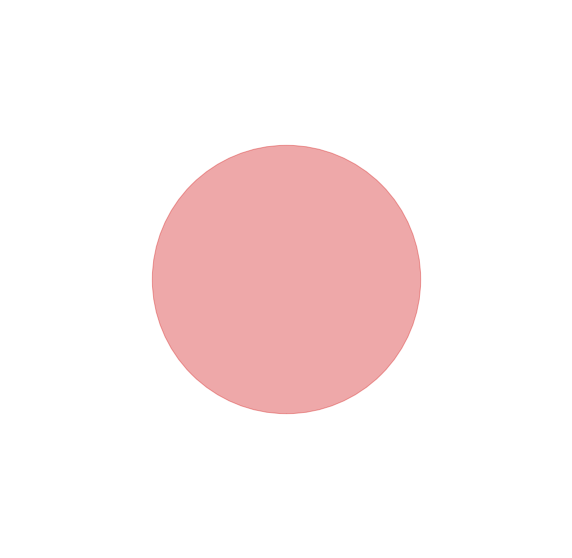

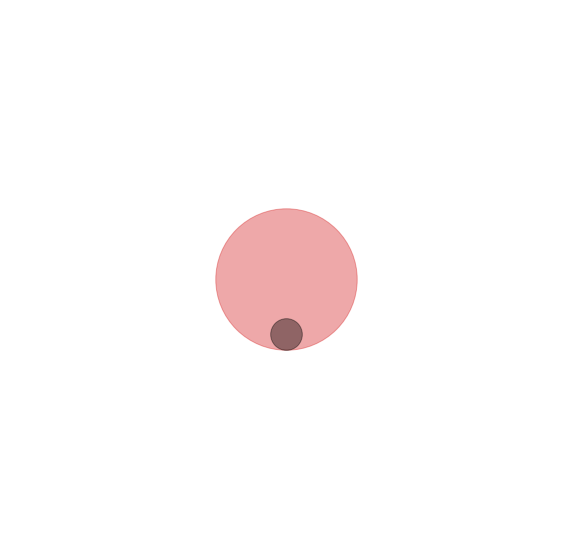

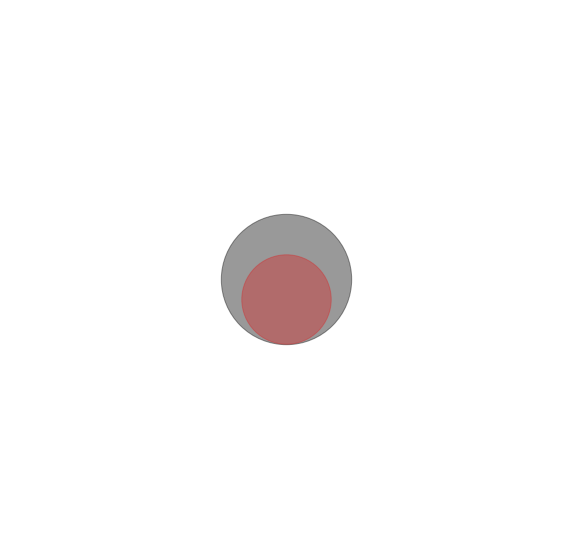

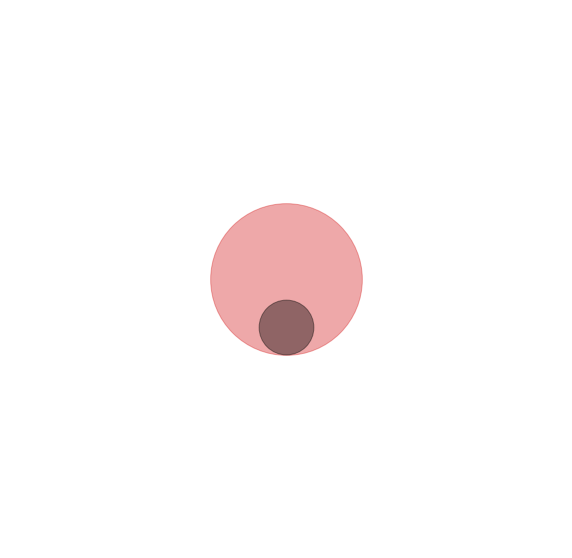

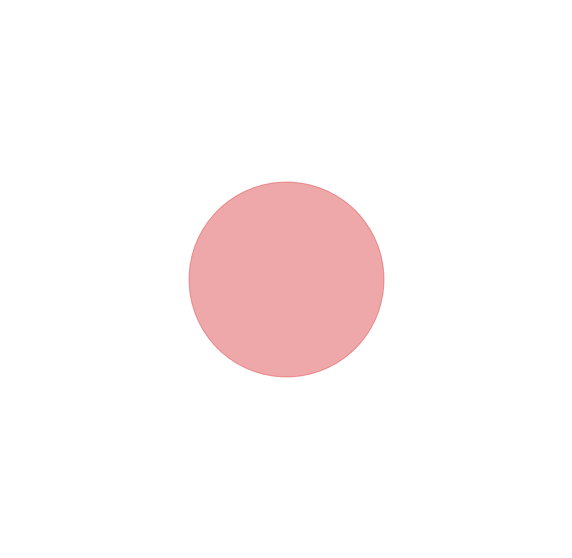

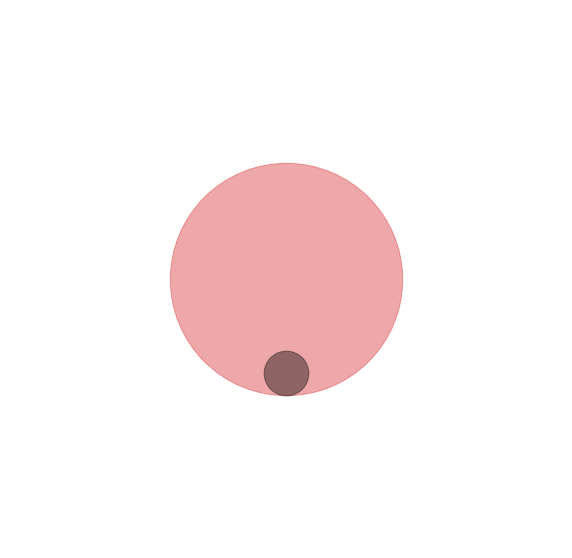

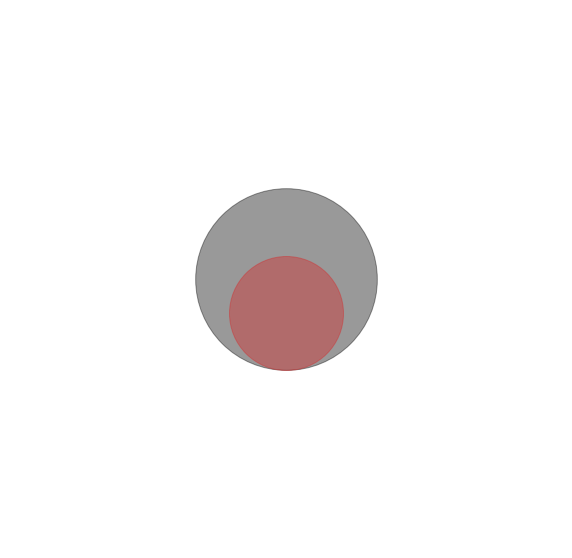

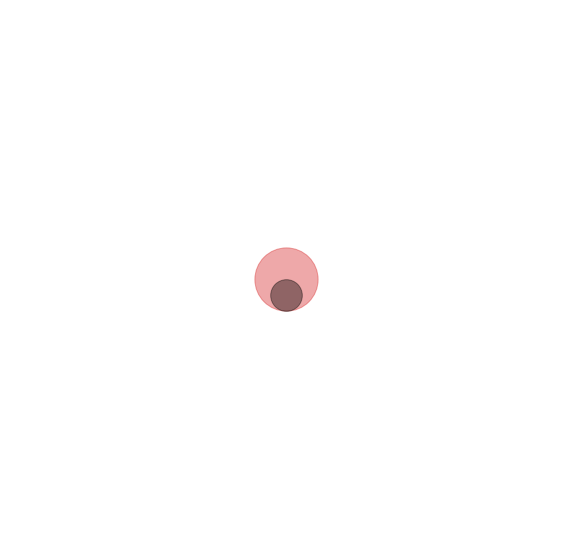

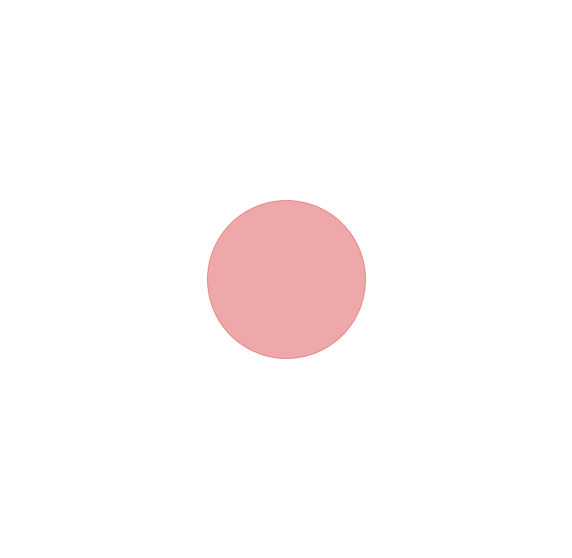

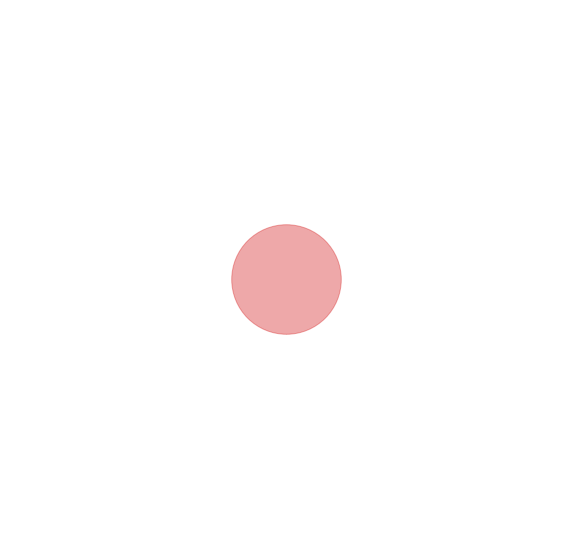

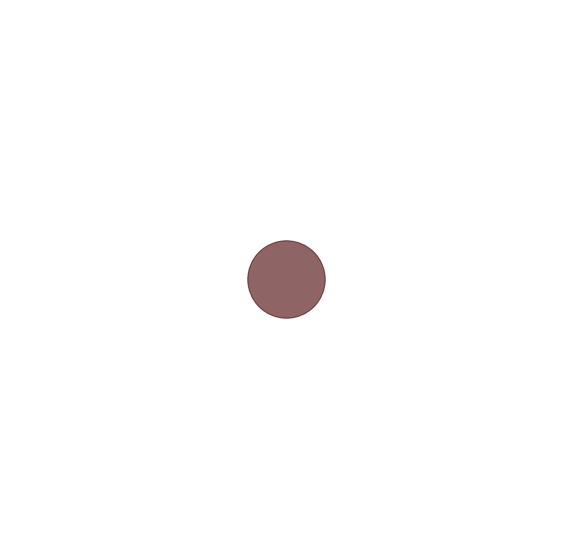

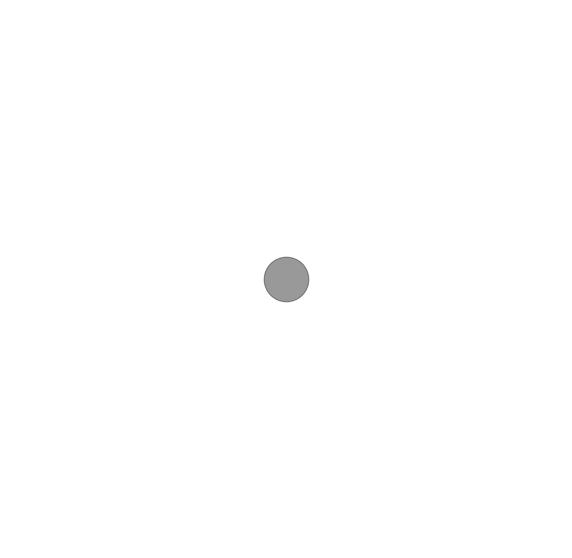

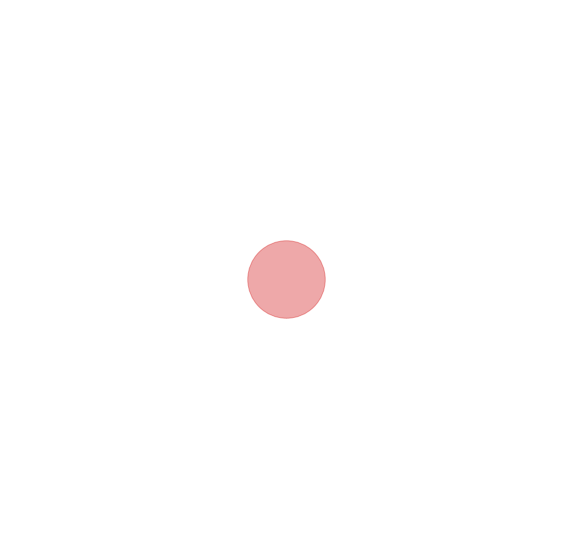

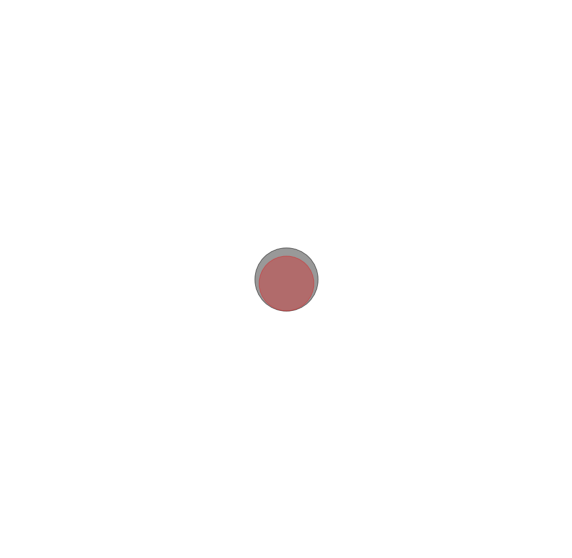

In [76]:
for organ in match_vess.keys():
    plt.figure(frameon=False, figsize=(10,10))
    plt.axis('off')
    plt.xlim(-0.025,0.025)
    plt.ylim(-0.025,0.025)
    if match_vess[organ]<=nomatch_vess[organ]:
        big_d = nomatch_vess[organ]+.000001
        small_d = match_vess[organ]+.000001
        big_color='tab:red'
        small_color='black'
    else:
        big_d=match_vess[organ]
        small_d = nomatch_vess[organ]
        big_color='black'
        small_color='tab:red'
    plt.scatter([0], [0], s=big_d*1000, c=big_color, alpha=0.4)
    plt.scatter([0], [(-np.sqrt(big_d)+np.sqrt(small_d))/690], s=small_d*1000, c=small_color, alpha=0.4)
    plt.savefig(f'{organ}.svg', bbox_inches='tight', pad_inches=0)


    # show the graph
    plt.show()

# Vascular network 

In [77]:
matching_nodes = vasc_data[(vasc_data['is_in_organ_table']==1)& (vasc_data.BodyPart!='testis')]

In [78]:
vasc_edges = pd.read_excel('./Blood_Vasculature_v1.2_EXTENDED.xlsx', sheet_name='Vessel')[['BranchesFrom', 'Vessel', 'VesselType']]
vasc_edges

,BranchesFrom,Vessel,VesselType
0,left atrium,left atrium,heart chamber
1,left atrium,left inferior pulmonary vein,vein
2,left atrium,left superior pulmonary vein,vein
3,left atrium,pulmonary vein,vein
4,pulmonary vein,segmental pulmonary vein,vein
...,...,...,...
956,right interlobar pulmonary artery,posterior segmental artery of right lung,artery
957,right interlobar pulmonary artery,superior segmental artery of right lung,artery
958,right pulmonary artery,truncus anterior of right pulmonary artery,artery
959,truncus anterior of right pulmonary artery,anterior segmental artery of right lung,artery


In [79]:
matching_nodes

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
154,eye,UBERON:0000970,capillary layer of choroid,capillary layer of choroid,UBERON:0005336,capillary,fenestrated,NaN,NaN,1,0,1
336,heart,UBERON:0000948,atrioventicular nodal artery,Atrioventricular node branch of right coronary...,FMA:3851,artery,NaN,NaN,NaN,1,0,1
337,heart,UBERON:0000948,conus artery,Conus artery,FMA:15736,artery,NaN,NaN,NaN,1,0,1
338,heart,UBERON:0000948,coronary sinus,coronary sinus,UBERON:0005438,sinus,NaN,NaN,NaN,1,0,1
339,heart,UBERON:0000948,diagonal branch of left anterior descending ar...,Diagonal branch of anterior descending branch ...,FMA:3860,artery,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
934,thyroid gland,UBERON:0002046,inferior thyroid vein,inferior thyroid vein,UBERON:0007156,vein,NaN,NaN,NaN,1,0,1
946,uterus,UBERON:0000995,arcuate artery of uterus,helicine branch of uterine artery,UBERON:0015173,artery,NaN,NaN,NaN,1,0,1
947,uterus,UBERON:0000995,artery of round ligament of uterus,Artery of round ligament of uterus,FMA:70195,artery,NaN,NaN,NaN,1,0,1
949,uterus,UBERON:0000995,uterine artery,uterine artery,UBERON:0002493,artery,NaN,NaN,NaN,1,0,1


In [80]:
vasc_edges = vasc_edges.rename(columns={'BranchesFrom':'source', 'Vessel': 'target'})
# vasc_edges.to_excel('vasc_edgelist.xlsx')

In [84]:
#Removal of the self-loops
vasc_edges = vasc_edges[vasc_edges.source!=vasc_edges.target]

In [85]:
vasc_graph = nx.from_pandas_edgelist(vasc_edges)

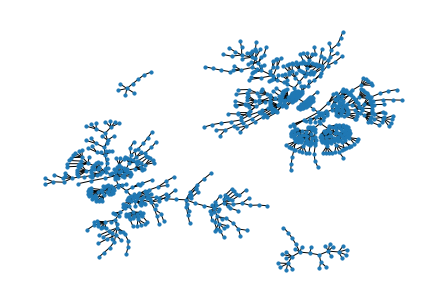

In [225]:
layout_pos_full = nx.drawing.nx_pydot.graphviz_layout(vasc_graph)

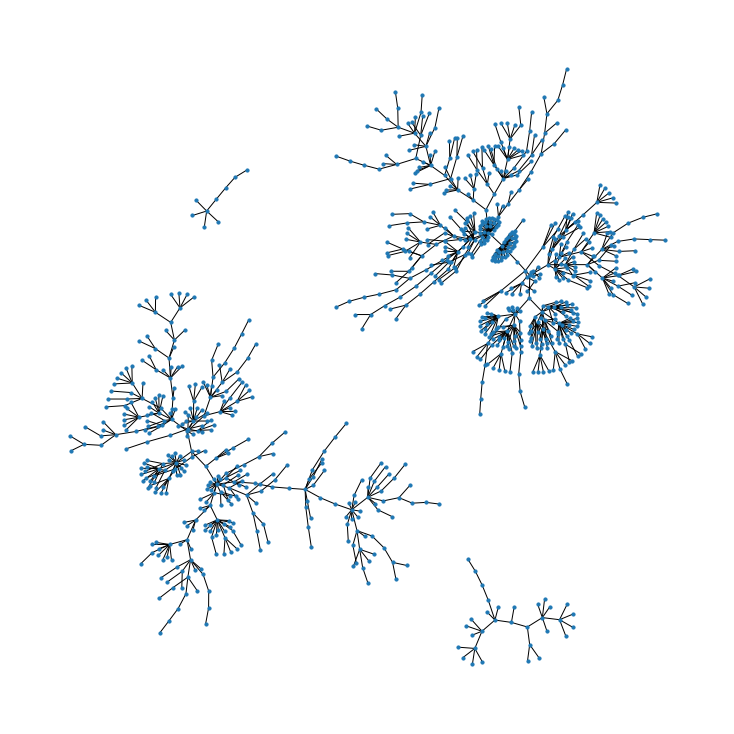

In [226]:
plt.figure(figsize=(10,10))
nx.draw(vasc_graph, pos=layout_pos_full, node_size=10)
plt.show()

### Construction of the pruned graph

The graph has to be pruned at the matching nodes

We start with the layer of matching nodes, and then in each iteration, we get the parent nodes (vessels), i.e. we are moving towards the core of the network in layers. 

In [86]:
layer = vasc_edges[vasc_edges.target.isin(matching_nodes.Vessel)]
layers = [layer]
indices = list(layer.index)
while len(layer):
    layer = vasc_edges[(vasc_edges.target.isin(layer.source)) & (~vasc_edges.index.isin(indices))]
    layers += [layer]
    indices += list(layer.index)

In [87]:
pruned_vasc_edges = vasc_edges[vasc_edges.index.isin(indices)]

Nodes of the pruned network:

In [88]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
0,abdominal cavity,UBERON:0003684,abdominal aorta,abdominal aorta,UBERON:0001516,artery,NaN,NaN,NaN,0,1,1
1,abdominal cavity,UBERON:0003684,celiac artery,celiac artery,UBERON:0001640,artery,NaN,NaN,NaN,0,1,1
6,abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,aorta,aorta,UBERON:0000947,artery,NaN,NaN,NaN,0,1,1
7,abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,inferior vena cava,posterior vena cava,UBERON:0001072,vein,NaN,NaN,NaN,0,1,1
8,abdominal wall,UBERON:0003697,inferior epigastric artery,inferior epigastric artery,UBERON:0001354,artery,NaN,NaN,NaN,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
946,uterus,UBERON:0000995,arcuate artery of uterus,helicine branch of uterine artery,UBERON:0015173,artery,NaN,NaN,NaN,1,0,1
947,uterus,UBERON:0000995,artery of round ligament of uterus,Artery of round ligament of uterus,FMA:70195,artery,NaN,NaN,NaN,1,0,1
949,uterus,UBERON:0000995,uterine artery,uterine artery,UBERON:0002493,artery,NaN,NaN,NaN,1,0,1
951,uterus,UBERON:0000995,uterine vein,Uterine vein,FMA:18896,vein,NaN,NaN,NaN,0,1,1


In [89]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))][['BodyPart', 'Vessel', 'VesselID', 'VesselType']].to_excel('nodes_of_vascular_network.xlsx')

In [90]:
pruned_vasc_edges.to_excel('vasc_edgelist.xlsx')
vasc_edges.to_excel('vasc_edgelist_all.xlsx')

In [91]:
pruned_vasc_graph = nx.from_pandas_edgelist(pruned_vasc_edges)

Note that the network is not connected, hence we have to add manually the 'heart' node and connect it to the components

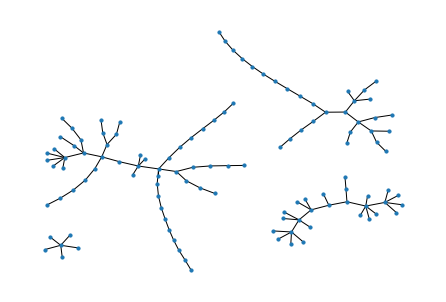

In [95]:
layout_pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph)
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)

Largest connected component

In [96]:
largest_cc = max(nx.connected_components(pruned_vasc_graph), key=len)

In [97]:
lcc = pruned_vasc_graph.subgraph(largest_cc).copy() 

In [98]:
nx.to_pandas_edgelist(lcc)

,source,target
0,ascending aorta,aorta
1,ascending aorta,aortic arch
2,ascending aorta,left coronary artery
3,ascending aorta,right coronary artery
4,sinoatrial nodal artery,right coronary artery
5,arcuate renal artery,interlobar renal artery
6,arcuate renal artery,interlobular renal artery
7,anterior division of internal iliac artery,internal iliac artery
8,anterior division of internal iliac artery,uterine artery
9,spleen central arteriole,spleen trabecular artery


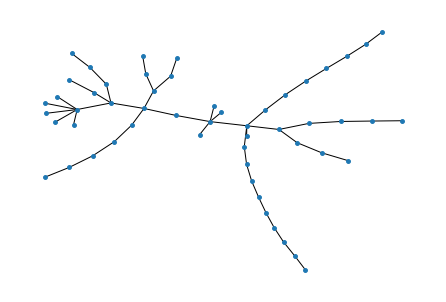

In [102]:
nx.draw(lcc, pos=layout_pos, node_size=15)

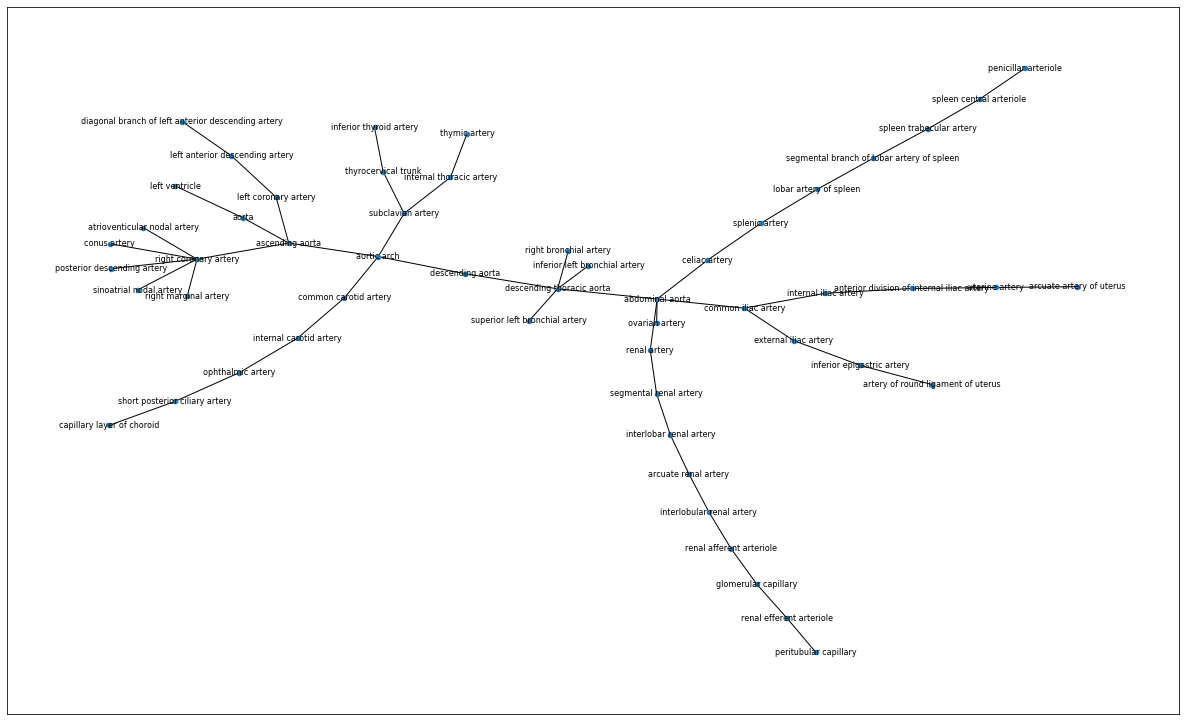

In [108]:
plt.figure(figsize=(21,13))
nx.draw_networkx(lcc, pos=layout_pos, node_size=20, font_size=8)

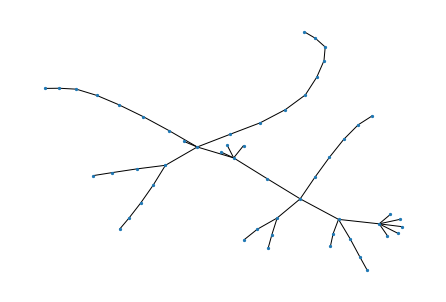

In [109]:
pos = nx.spring_layout(lcc, seed=4)
nx.draw(lcc, pos=pos, node_size=5)

Specifying the coordinates of one node

In [138]:
pos={'superior left bronchial artery': np.array([1, -1])}

pos2 = nx.spring_layout(lcc, pos=pos, fixed=['superior left bronchial artery'], seed=5)

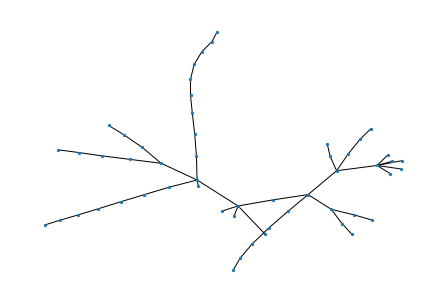

In [139]:
nx.draw(lcc, pos2, node_size=5)

## Bundling the edges 

In [140]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

In [141]:
nx.convert_node_labels_to_integers(lcc, label_attribute='name')

In [713]:
lcc_renamed = nx.convert_node_labels_to_integers(lcc, label_attribute='name')

In [714]:
lcc_nodes_only = pd.DataFrame.from_dict(dict(lcc_renamed.nodes(data=True)), orient='index')[['name']]

In [715]:
lcc_nodes_only.head()

,name
0,ascending aorta
1,sinoatrial nodal artery
2,arcuate renal artery
3,anterior division of internal iliac artery
4,spleen central arteriole


In [716]:
pos={0: np.array([1, -1])}
pos2 = nx.spring_layout(lcc_renamed, pos=pos, fixed=[0], seed=6, iterations=100)

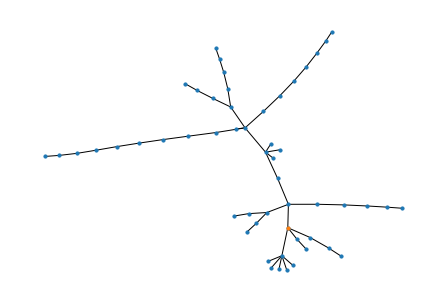

In [717]:
nx.draw(lcc_renamed, pos2, node_size=10)
nx.draw_networkx_nodes(lcc_renamed, pos2, nodelist=[0], node_color='tab:orange', node_size=10)
plt.savefig('small_network.png', dpi=300)
plt.show()

In [718]:
lcc_nodes = pd.DataFrame.from_dict(pos2).T.rename(columns={0:'x', 1:'y'}).join(lcc_nodes_only)[['name', 'x', 'y']]

In [719]:
lcc_edges = nx.to_pandas_edgelist(lcc_renamed)[['source', 'target']]

In [929]:
hb = hammer_bundle(lcc_nodes, lcc_edges)#, initial_bandwidth=.05, decay=0.2, tension=0.99)

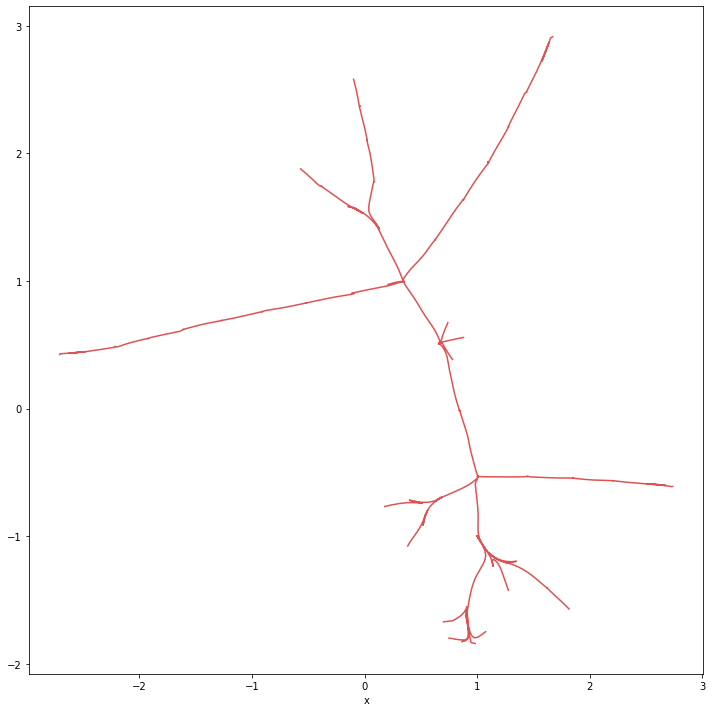

In [930]:
hb.plot(x='x', y='y', color='tab:red', alpha=0.8, figsize=(10,10), legend=False)
plt.tight_layout()
# plt.savefig('example.png', dpi=300)
plt.show()

In [941]:
hb = hammer_bundle(lcc_nodes, lcc_edges, initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)

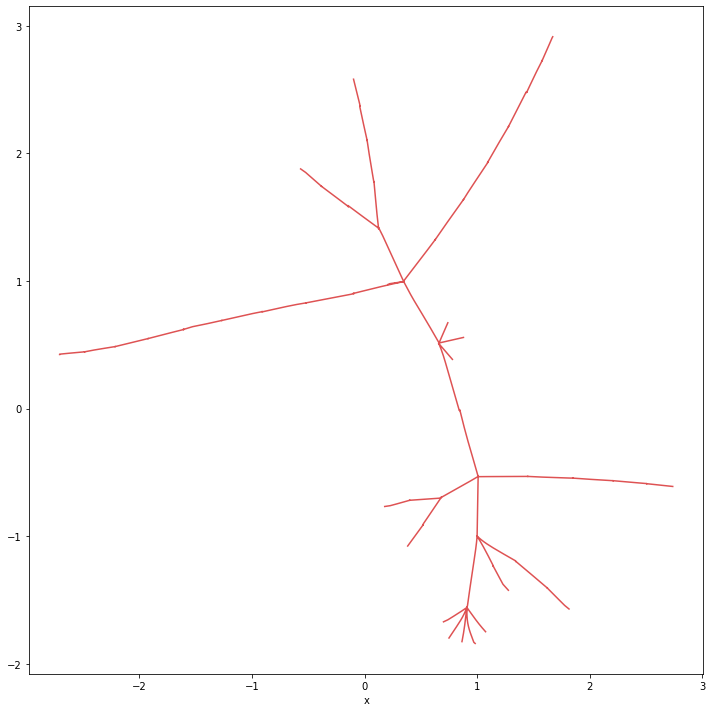

In [942]:
hb.plot(x='x', y='y', color='tab:red', alpha=0.8, figsize=(10,10), legend=False)
plt.tight_layout()
# plt.savefig('example.png', dpi=300)
plt.show()

### Get the coordinates from the Vega visualization 

In [573]:
with open('viz_female_2.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [574]:
female_viz = viz['data'][0]['values']

In [575]:
female_viz[:2]

[{'id': 0,
  'name': 'Body',
  'type': 'AS',
  'ontology_id': 'UBERON:0013702',
  'color': '#984ea3',
  'organ': 'body',
  'alpha': 0.43872052075552237,
  'radius': 0,
  'depth': 0,
  'children': 20,
  'angle': 257.9393874719881,
  'radians': 4.501891581963605,
  'leftside': True,
  'x': 860,
  'y': 860},
 {'id': 1,
  'name': 'Bone marrow',
  'parent': 0,
  'type': 'AS',
  'ontology_id': 'UBERON:0002371',
  'color': '#984ea3',
  'organ': 'bone_marrow',
  'alpha': 0.010244370931597482,
  'radius': 58.333333333333336,
  'depth': 1,
  'children': 47,
  'angle': 103.68797353537514,
  'radians': 1.809696532913041,
  'leftside': True,
  'x': 846.1963376727464,
  'y': 916.6765973231716}]

In [576]:
matching_nodes.head()

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels,organ
154,eye,UBERON:0000970,capillary layer of choroid,capillary layer of choroid,UBERON:0005336,capillary,fenestrated,NaN,NaN,1,0,1,eye
336,heart,UBERON:0000948,atrioventicular nodal artery,Atrioventricular node branch of right coronary...,FMA:3851,artery,NaN,NaN,NaN,1,0,1,heart
337,heart,UBERON:0000948,conus artery,Conus artery,FMA:15736,artery,NaN,NaN,NaN,1,0,1,heart
338,heart,UBERON:0000948,coronary sinus,coronary sinus,UBERON:0005438,sinus,NaN,NaN,NaN,1,0,1,heart
339,heart,UBERON:0000948,diagonal branch of left anterior descending ar...,Diagonal branch of anterior descending branch ...,FMA:3860,artery,NaN,NaN,NaN,1,0,1,heart


Merge of heart & heart chamber, thyroid gland & lund, 

In [155]:
organ_mapping = {'eye': 'eye', 'heart': 'heart', 'heart chamber': 'heart', 'kidney': 'kidney', 
                 'liver': 'liver', 'lung': 'lung', 'ovary': 'ovary', 'spleen': 'spleen', 
                 'thymus': 'thymus', 'thyroid gland': 'lung', 'uterus': 'uterus'}

In [156]:
matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])

C:\Users\slapj\AppData\Local\Temp\ipykernel_1504\3296384991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])


Get the coordinates for the vessels

In [158]:
arteries = nx.to_pandas_edgelist(lcc)
arteries_nodes = set(arteries[['source', 'target']].values.flatten())

In [265]:
name = []
name_in_vasc = []
x_coords=[]
y_coords=[]
organs = []
for node in female_viz:
    if node['ontology_id'] in matching_nodes['VesselID'].values:
        if node['organ']==matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['organ'].values[0]:
            name += [node['name']]
            name_in_vasc += [matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['Vessel'].values[0]]
            x_coords += [node['x']]
            y_coords += [node['y']]
            organs += [node['organ']]
    
for node in arteries_nodes:
    if node not in name:
        name += [node]
        name_in_vasc += [node]
        x_coords += [np.nan]
        y_coords += [np.nan]
        organs += [np.nan]
        
art_data = pd.DataFrame.from_dict({'name': name, 'name_in_vasc': name_in_vasc,
                                   'organ': organs, 'x': x_coords, 'y': y_coords})

In [266]:
art_data = art_data.drop_duplicates(subset=['name_in_vasc', 'organ']).reset_index(drop=True)

In [267]:
art_data

,name,name_in_vasc,organ,x,y
0,arcuate artery of uterus,arcuate artery of uterus,uterus,790.288261,1082.676263
1,,uterine artery,uterus,797.977200,1023.640375
2,artery of round ligament of uterus,artery of round ligament of uterus,uterus,818.582392,969.067378
3,uterine venous plexsus,uterine venous plexus,uterus,818.444293,969.014835
4,ovarian artery,ovarian artery,ovary,764.355746,1006.550935
...,...,...,...,...,...
102,aortic arch,aortic arch,NaN,NaN,NaN
103,internal thoracic artery,internal thoracic artery,NaN,NaN,NaN
104,glomerular capillary,glomerular capillary,NaN,NaN,NaN
105,descending aorta,descending aorta,NaN,NaN,NaN


## Full graph

In [577]:
def get_coordinates_4_vessels(visualization, graph=pruned_vasc_graph):
    name = []
    name_in_vasc = []
    coords=[]
    organs = []
    for node in visualization:
        if node['ontology_id'] in matching_nodes['VesselID'].values:
            if node['organ']==matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['organ'].values[0]:
                name += [node['name']]
                name_in_vasc += [matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['Vessel'].values[0]]
                coords += [np.array([node['x'], -node['y']])]
                organs += [node['organ']]

    for node in graph:
        if node not in name_in_vasc:
            name += [node]
            name_in_vasc += [node]
            coords += [np.nan]
            organs += [np.nan]

    art_data = pd.DataFrame.from_dict({'name': name, 'name_in_vasc': name_in_vasc,
                                       'organ': organs, 'coords': coords})
    
    art_data = art_data.drop_duplicates(subset=['name_in_vasc', 'organ']).reset_index(drop=True) 
    
    art_data = art_data[art_data.name_in_vasc.isin(graph.nodes())]
    
    return art_data

In [578]:
coords = get_coordinates_4_vessels(female_viz)

In [579]:
coords.head()

,name,name_in_vasc,organ,coords
0,arcuate artery of uterus,arcuate artery of uterus,uterus,"[759.0497380620037, -1070.3651327076195]"
1,,uterine artery,uterus,"[765.2500541341117, -1007.1307165700325]"
2,artery of round ligament of uterus,artery of round ligament of uterus,uterus,"[796.701892865377, -958.0023507079544]"
3,uterine venous plexsus,uterine venous plexus,uterus,"[796.4392814625401, -957.8322348212128]"
4,ovarian artery,ovarian artery,ovary,"[710.0257791468148, -950.1816670919318]"


In [580]:
len(coords)

117

In [581]:
relabel_mapping = coords['name_in_vasc'].to_dict()
relabel_mapping = {v: k for k, v in relabel_mapping.items()}

In [582]:
renamed_pruned_vasc = nx.relabel_nodes(pruned_vasc_graph, relabel_mapping)

In [583]:
pos = coords['coords'].dropna().to_dict()

In [584]:
pos2 = nx.spring_layout(renamed_pruned_vasc, pos=pos, fixed=list(pos.keys()), iterations=1000)

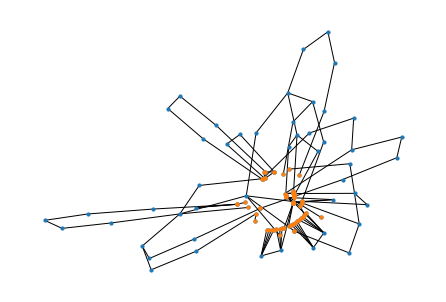

In [585]:
nx.draw(renamed_pruned_vasc, pos2, node_size=10)
nx.draw_networkx_nodes(renamed_pruned_vasc, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
# plt.savefig('small_network.png', dpi=300)
plt.show()

In [586]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

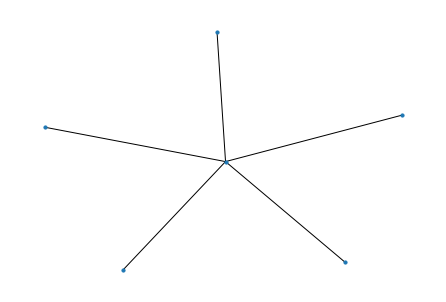

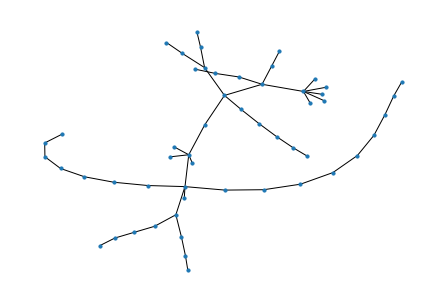

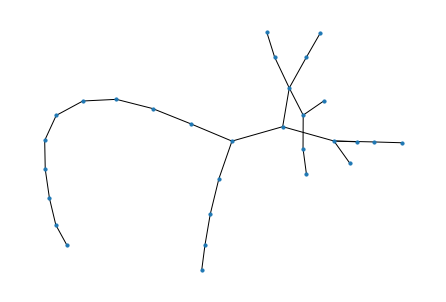

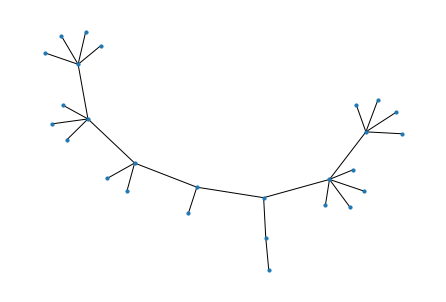

In [548]:
for comp in connected_comps:
    nx.draw(comp, node_size=10)
    plt.show()

In [943]:
def plot_fixed_graph(graph, bundle_edges=False, draw_labels=False):
    coords = get_coordinates_4_vessels(female_viz, graph)
    relabel_mapping_inv = coords['name_in_vasc'].to_dict()
    relabel_mapping = {v: k for k, v in relabel_mapping_inv.items()}
    
    renamed_comp = nx.relabel_nodes(graph, relabel_mapping)
    
    pos = coords['coords'].dropna().to_dict()
    pos2 = nx.spring_layout(renamed_comp, pos=pos, fixed=list(pos.keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graph)))
    
    if not bundle_edges:
        plt.figure(figsize=(20,20))
        plt.axes().set_aspect('equal')
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        nx.draw(renamed_comp, pos2, node_size=10, edge_color='tab:red')
        if draw_labels:
            nx.draw_networkx_labels(renamed_comp, pos2, labels=relabel_mapping_inv, font_size=3)
        nx.draw_networkx_nodes(renamed_comp, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig('vasculature.svg',  transparent=True)
        plt.show()
    else:
        nodes_only = pd.DataFrame.from_dict(relabel_mapping_inv, orient='index').rename(columns={0:'name'})
        nodes = pd.DataFrame.from_dict(pos2).T.rename(columns={0:'x', 1:'y'}).join(nodes_only)[['name', 'x', 'y']]
        edges = nx.to_pandas_edgelist(renamed_comp)[['source', 'target']]
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        hb = hammer_bundle(nodes, edges, initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)
        hb.plot(x='x', y='y', color='tab:red', alpha=0.8, figsize=(20,20), legend=False, xlim=(0,1720), ylim=(-1720, 0)).set_aspect('equal')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('vasculature_bundled.svg')
        plt.show()

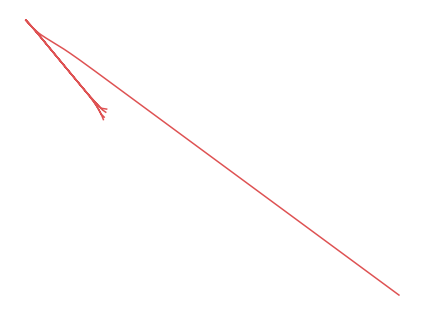

In [551]:
plot_fixed_graph(connected_comps[0], bundle_edges=True)

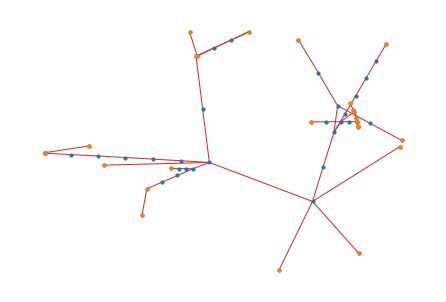

In [552]:
plot_fixed_graph(connected_comps[1])

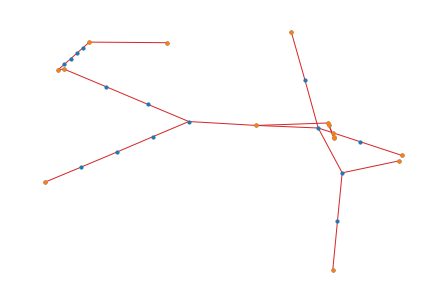

In [553]:
plot_fixed_graph(connected_comps[2])

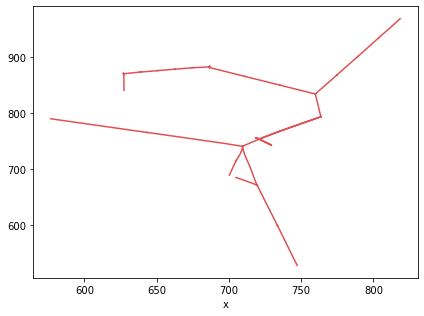

In [482]:
plot_fixed_graph(connected_comps[2], bundle_edges=True)

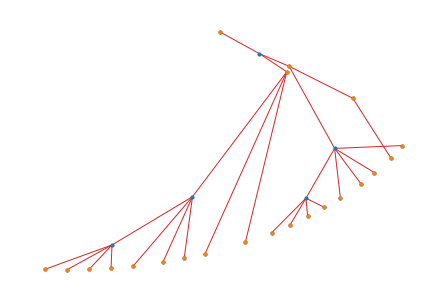

In [554]:
plot_fixed_graph(connected_comps[3])

In [556]:
get_coordinates_4_vessels(female_viz,connected_comps[3])

,name,name_in_vasc,organ,coords
33,right ventricle,right ventricle,heart,"[976.6640732989654, -859.2221102875394]"
40,Right Main Pulmonary Artery,right pulmonary artery,lung,"[1029.9810848600043, -901.6104649074728]"
43,Left Main Pulmonary Artery,left pulmonary artery,lung,"[1028.1700344848737, -908.4132161848025]"
46,Right Upper Pulmonary Artery trunk,truncus anterior of right pulmonary artery,lung,"[1078.8605410675216, -940.8981335265293]"
51,Right Posterior Segmental Pulmonary Artery,posterior segmental artery of right lung,lung,"[1116.3976958340775, -999.0311692226614]"
52,Right Anterior Segmental Pulmonary Artery,anterior segmental artery of right lung,lung,"[1107.856109081393, -1013.7426214017344]"
53,Right Lateral Segmental Pulmonary Artery,lateral segmental artery of right lung,lung,"[1095.3923599776351, -1032.220443933361]"
54,Right Medial Segmental Pulmonary Artery,medial segmental artery of right lung,lung,"[1084.951573587175, -1045.6508389022206]"
55,Right Superior Segmental Pulmonary Artery,superior segmental artery of right lung,lung,"[1069.302647200084, -1063.1301216449237]"
56,Right Medial Basal Segmental Pulmonary Artery,medial basal segmental artery of right lung,lung,"[1057.1042090635976, -1074.9869187040413]"


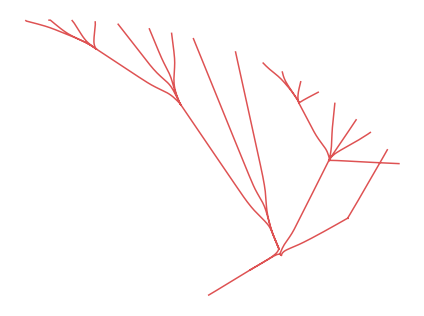

In [520]:
plot_fixed_graph(connected_comps[3], bundle_edges=True)

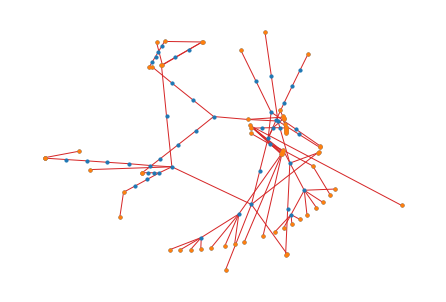

In [557]:
plot_fixed_graph(pruned_vasc_graph, bundle_edges=False)

In [147]:
lcc_nodes = pd.DataFrame.from_dict(pos2).T.rename(columns={0:'x', 1:'y'}).join(lcc_nodes_only)[['name', 'x', 'y']]

In [148]:
lcc_edges = nx.to_pandas_edgelist(lcc_renamed)[['source', 'target']]

In [149]:
hb = hammer_bundle(lcc_nodes, lcc_edges, initial_bandwidth=0.03,tension=0.9, accuracy=2000)

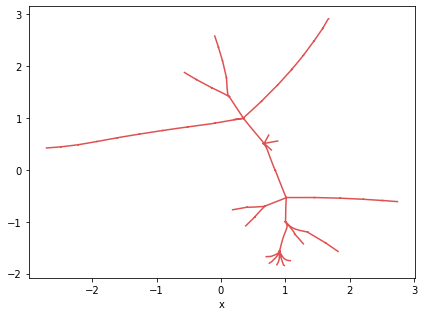

In [150]:
hb.plot(x='x', y='y', color='tab:red', alpha=0.8, figsize=(6,4.5), legend=False)
plt.tight_layout()
plt.savefig('example.png', dpi=300)
plt.show()

In [269]:
len(pruned_vasc_graph)

117

#### Origins of duplicated nodes:

In [176]:
art_data[~art_data['x'].isna()]

,name,name_in_vasc,organ,x,y
0,arcuate artery of uterus,arcuate artery of uterus,uterus,790.288261,1082.676263
1,arcuate artery of uterus,arcuate artery of uterus,uterus,784.880701,1080.910695
2,,uterine artery,uterus,797.977200,1023.640375
3,artery of round ligament of uterus,artery of round ligament of uterus,uterus,818.582392,969.067378
4,uterine venous plexsus,uterine venous plexus,uterus,818.444293,969.014835
...,...,...,...,...,...
140,Pulmonary Vein,pulmonary vein,lung,831.708809,452.647917
141,inferior left bronchial artery,inferior left bronchial artery,lung,834.675991,452.452695
142,left bronchial vein,left bronchial vein,lung,836.224628,452.359420
143,Left Posterior Basal Segmental Pulmonary Artery,posterior basal segmental artery of left lung,lung,844.308432,568.755740


In [190]:
art_data[art_data.duplicated(subset=['name_in_vasc', 'organ'], keep=False)]

,name,name_in_vasc,organ,x,y
0,arcuate artery of uterus,arcuate artery of uterus,uterus,790.288261,1082.676263
1,arcuate artery of uterus,arcuate artery of uterus,uterus,784.880701,1080.910695
11,Splenic Artery,splenic artery,spleen,685.583030,874.273069
12,Spleen central arteriole,spleen central arteriole,spleen,685.521475,873.499793
14,Splenic Vein,splenic vein,spleen,626.950807,871.511655
...,...,...,...,...,...
138,left bronchial vein,left bronchial vein,lung,825.006173,453.168901
140,Pulmonary Vein,pulmonary vein,lung,831.708809,452.647917
141,inferior left bronchial artery,inferior left bronchial artery,lung,834.675991,452.452695
142,left bronchial vein,left bronchial vein,lung,836.224628,452.359420


In [191]:
list(nx.neighbors(pruned_vasc_graph, 'arcuate artery of uterus'))

['uterine artery']

In [209]:
leaves = []
for vessel in art_data[art_data.duplicated(subset=['name_in_vasc', 'organ'], keep=False)].name_in_vasc.values:
    if len(list(nx.neighbors(pruned_vasc_graph, vessel)))>1:
        print(vessel)
    else:
          leaves += [vessel]

splenic artery
spleen central arteriole
splenic vein
spleen central arteriole
splenic artery
splenic vein


In [194]:
list(nx.neighbors(pruned_vasc_graph, 'splenic artery'))

['celiac artery', 'lobar artery of spleen']

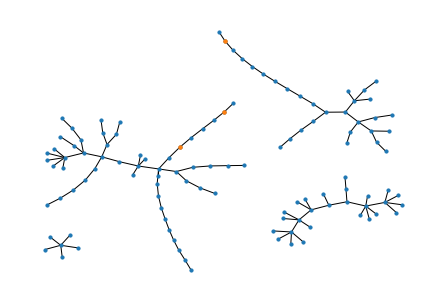

In [198]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=['splenic artery', 'spleen central arteriole', 'splenic vein'], 
                       node_color='tab:orange', node_size=12)
plt.show()

In [201]:
arteries[arteries['source']=='splenic artery']

,source,target
18,splenic artery,lobar artery of spleen


In [203]:
matching_nodes[matching_nodes.Vessel=='splenic artery']

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels,organ
818,spleen,UBERON:0002106,splenic artery,splenic artery,UBERON:0001194,artery,NaN,NaN,NaN,1,0,1,spleen


In [208]:
nodes[nodes.ontology_id=='UBERON:0001194']

,id,id_old,name,type,organ,ontology_id
1884,1884,3,Splenic Artery,AS,spleen,UBERON:0001194
1919,1919,38,Splenic Artery,AS,spleen,UBERON:0001194


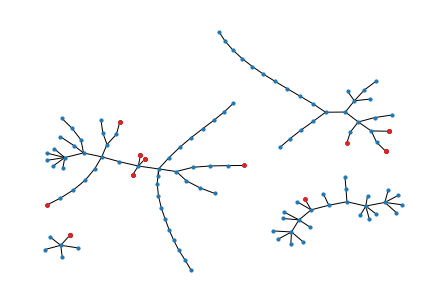

In [211]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=leaves, 
                       node_color='tab:red', node_size=12)
plt.show()

In [229]:
leaves_of_pruned = [node for node in pruned_vasc_graph if nx.degree(pruned_vasc_graph, node)==1]

In [230]:
len(leaves_of_pruned)

51

In [232]:
matching_not_leaf = [node for node in matching_nodes.Vessel.values if node not in leaves_of_pruned]

In [233]:
matching_leaf = [node for node in matching_nodes.Vessel.values if node in leaves_of_pruned]

In [236]:
len(matching_not_leaf)+len(matching_leaf)

69

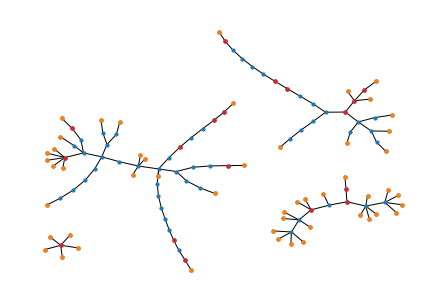

In [237]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_not_leaf, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.show()

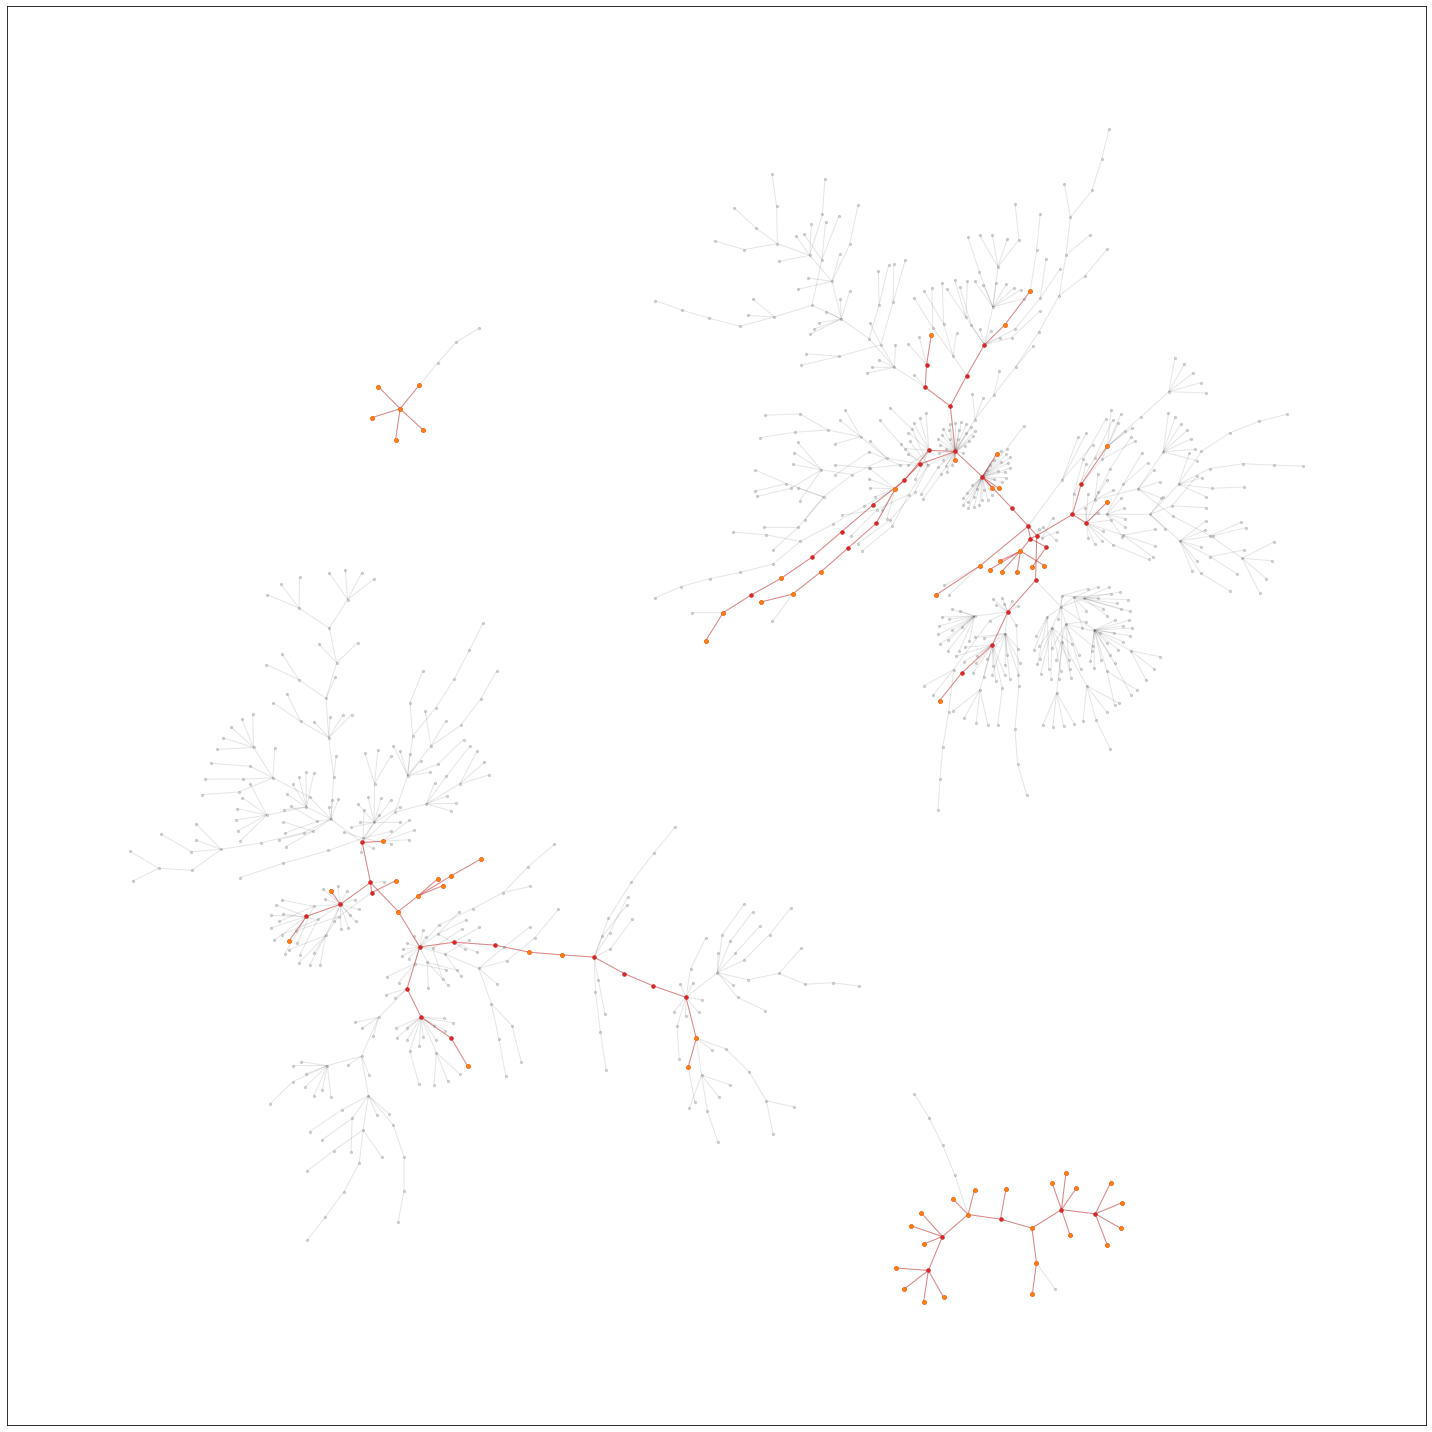

In [253]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(vasc_graph, pos=layout_pos_full, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_edges(vasc_graph, pos=layout_pos_full, alpha=0.1)
nx.draw_networkx_edges(pruned_vasc_graph, pos=layout_pos_full, alpha=0.5, edge_color='tab:red')
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=pruned_vasc_graph.nodes, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_not_leaf, 
                       node_color='tab:orange', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.tight_layout()
plt.savefig('vascular.png', dpi=300)
plt.show()

# Connect the components of the vascular network 

In [610]:
# Load json files 
json_data_asctb_blood = {}
for filename in listdir('./asct+b/'):
    if '.json' in filename:
        # print(filename)
        with open(f'./asct+b/{filename}', encoding='utf8') as json_file:
            data = json.load(json_file)

        json_data_asctb_blood[filename[:-5]] = data

In [611]:
json_data_asctb_blood.keys()

dict_keys(['blood', 'blood_vasculature', 'bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_nodes', 'lymph_vasculature', 'ovary', 'pancreas', 'peripheral_nervous_system', 'prostate', 'skin', 'small_intestine', 'spleen', 'thymus', 'ureter', 'urinary_bladder', 'uterus'])

In [608]:
nodes, edges = combine_data(json_data_asctb_blood, remove_ctct=True, combine=False, blood=True)

blood is tree: True
blood_vasculature is tree: True
bone_marrow is tree: True
brain is tree: True
eye is tree: True
fallopian_tube is tree: True
heart is tree: True
kidney is tree: True
knee is tree: True
large_intestine is tree: True
liver is tree: True
lung is tree: True
lymph_nodes is tree: True
ovary is tree: True
pancreas is tree: True
prostate is tree: True
skin is tree: True
small_intestine is tree: True
spleen is tree: True
thymus is tree: True
ureter is tree: True
urinary_bladder is tree: True
uterus is tree: True


In [614]:
blood_vasc_nodes = nodes['blood_vasculature']

In [615]:
blood_vasc_edges = edges['blood_vasculature']

In [616]:
blood_vasc_nodes

,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
1705,1705,871,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071
1706,1706,871,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071
1707,1707,871,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071


In [618]:
blood_vasc_graph = nx.from_pandas_edgelist(blood_vasc_edges)

In [621]:
blood_vasc_graph = nx.relabel_nodes(blood_vasc_graph, blood_vasc_nodes['name'].to_dict())

In [656]:
pos = nx.drawing.nx_pydot.graphviz_layout(blood_vasc_graph, root='blood vasculature')

In [636]:
[node for node in pruned_vasc_graph if node not in blood_vasc_graph]

['pulmonary vein',
 'short posterior ciliary artery',
 'lobar artery of spleen',
 'segmental branch of lobar artery of spleen',
 'segmental branch of hepatic vein',
 'hepatic portal venule',
 'lateral inferior segmental branch of left hepatic portal vein',
 'left hepatic portal vein']

In [952]:
subgraph = nx.induced_subgraph(blood_vasc_graph, list(pruned_vasc_graph.nodes)+['blood vasculature'])

In [953]:
pos = nx.drawing.nx_pydot.graphviz_layout(subgraph, root='blood vasculature')

In [954]:
pos_of_pruned = nx.spring_layout(pruned_vasc_graph, pos=pos, fixed=pos.keys(), iterations=1000, dim=2, k=0.01/np.sqrt(len(pruned_vasc_graph)))

In [955]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

In [956]:
new_edges = [edge for edge in subgraph.edges if edge not in pruned_vasc_graph.edges]

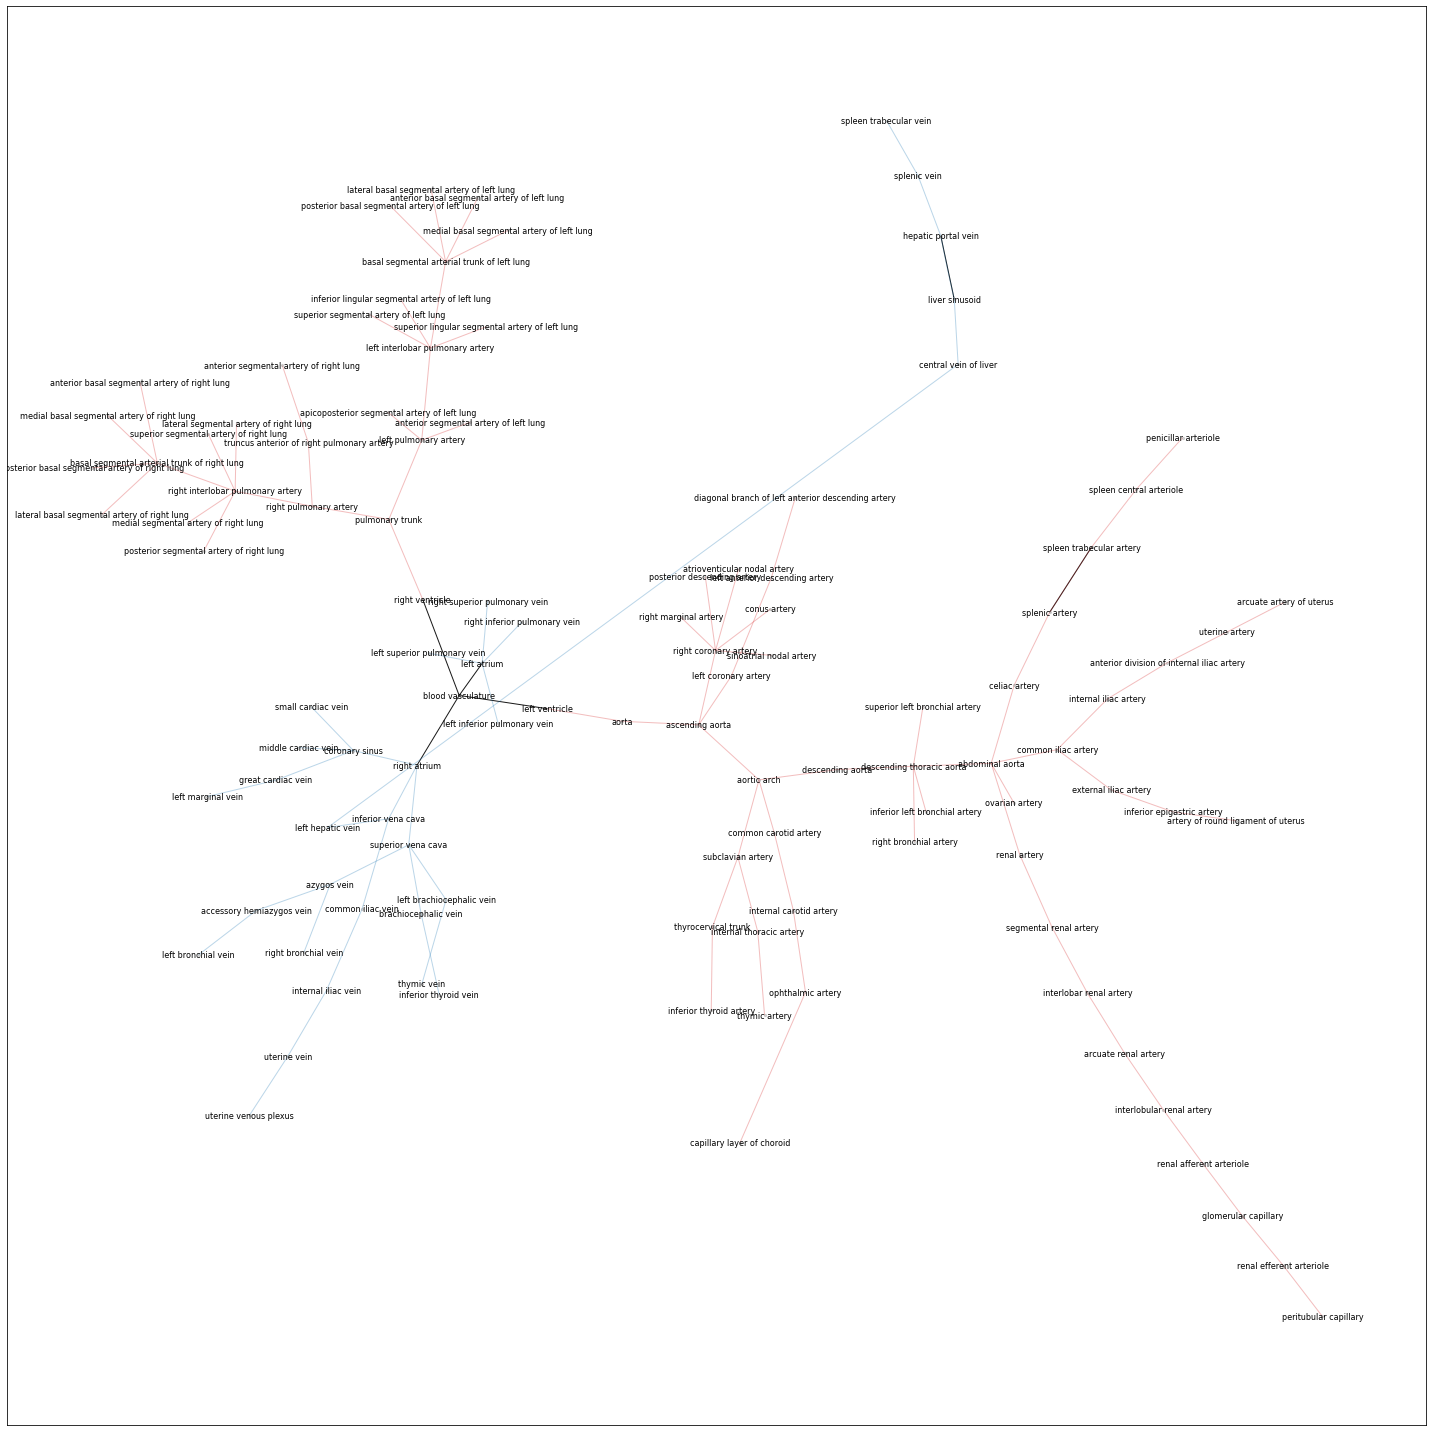

In [957]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(subgraph, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(subgraph, pos=pos, font_size=8)
nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

colors = ['tab:blue','tab:red', 'tab:blue', 'tab:red']
for idx, comp in enumerate(connected_comps):
    nx.draw_networkx_edges(comp, pos=pos_of_pruned, alpha=0.3, edge_color=colors[idx])

plt.tight_layout()
plt.savefig('completed_vascular.png', dpi=350)
plt.show()

In [948]:
new_edges

[('liver sinusoid', 'hepatic portal vein'),
 ('blood vasculature', 'left atrium'),
 ('blood vasculature', 'left ventricle'),
 ('blood vasculature', 'right atrium'),
 ('blood vasculature', 'right ventricle'),
 ('spleen trabecular artery', 'splenic artery')]

In [682]:
[edge for edge in pruned_vasc_graph.edges if edge[0] in ['liver sinusoid']]

[('liver sinusoid', 'hepatic portal venule')]

In [683]:
[edge for edge in subgraph.edges if edge[0] in ['liver sinusoid']]

[('liver sinusoid', 'hepatic portal vein')]

In [684]:
[edge for edge in pruned_vasc_graph.edges if edge[0] in ['spleen trabecular artery']]

[('spleen trabecular artery', 'spleen central arteriole')]

In [685]:
[edge for edge in subgraph.edges if edge[0] in ['spleen trabecular artery']]

[('spleen trabecular artery', 'splenic artery')]

### add edges

In [688]:
pruned_vasc_graph_comp = pruned_vasc_graph.copy()

In [689]:
pruned_vasc_graph_comp.add_edges_from([('blood vasculature', 'left atrium'),('blood vasculature', 'left ventricle'),
                                       ('blood vasculature', 'right atrium'), ('blood vasculature', 'right ventricle')])

In [992]:
veins = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[1]) and (node not in connected_comps[3])]

In [993]:
arteries = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[0]) and (node not in connected_comps[2])]

In [994]:
pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph_comp, root='blood vasculature')

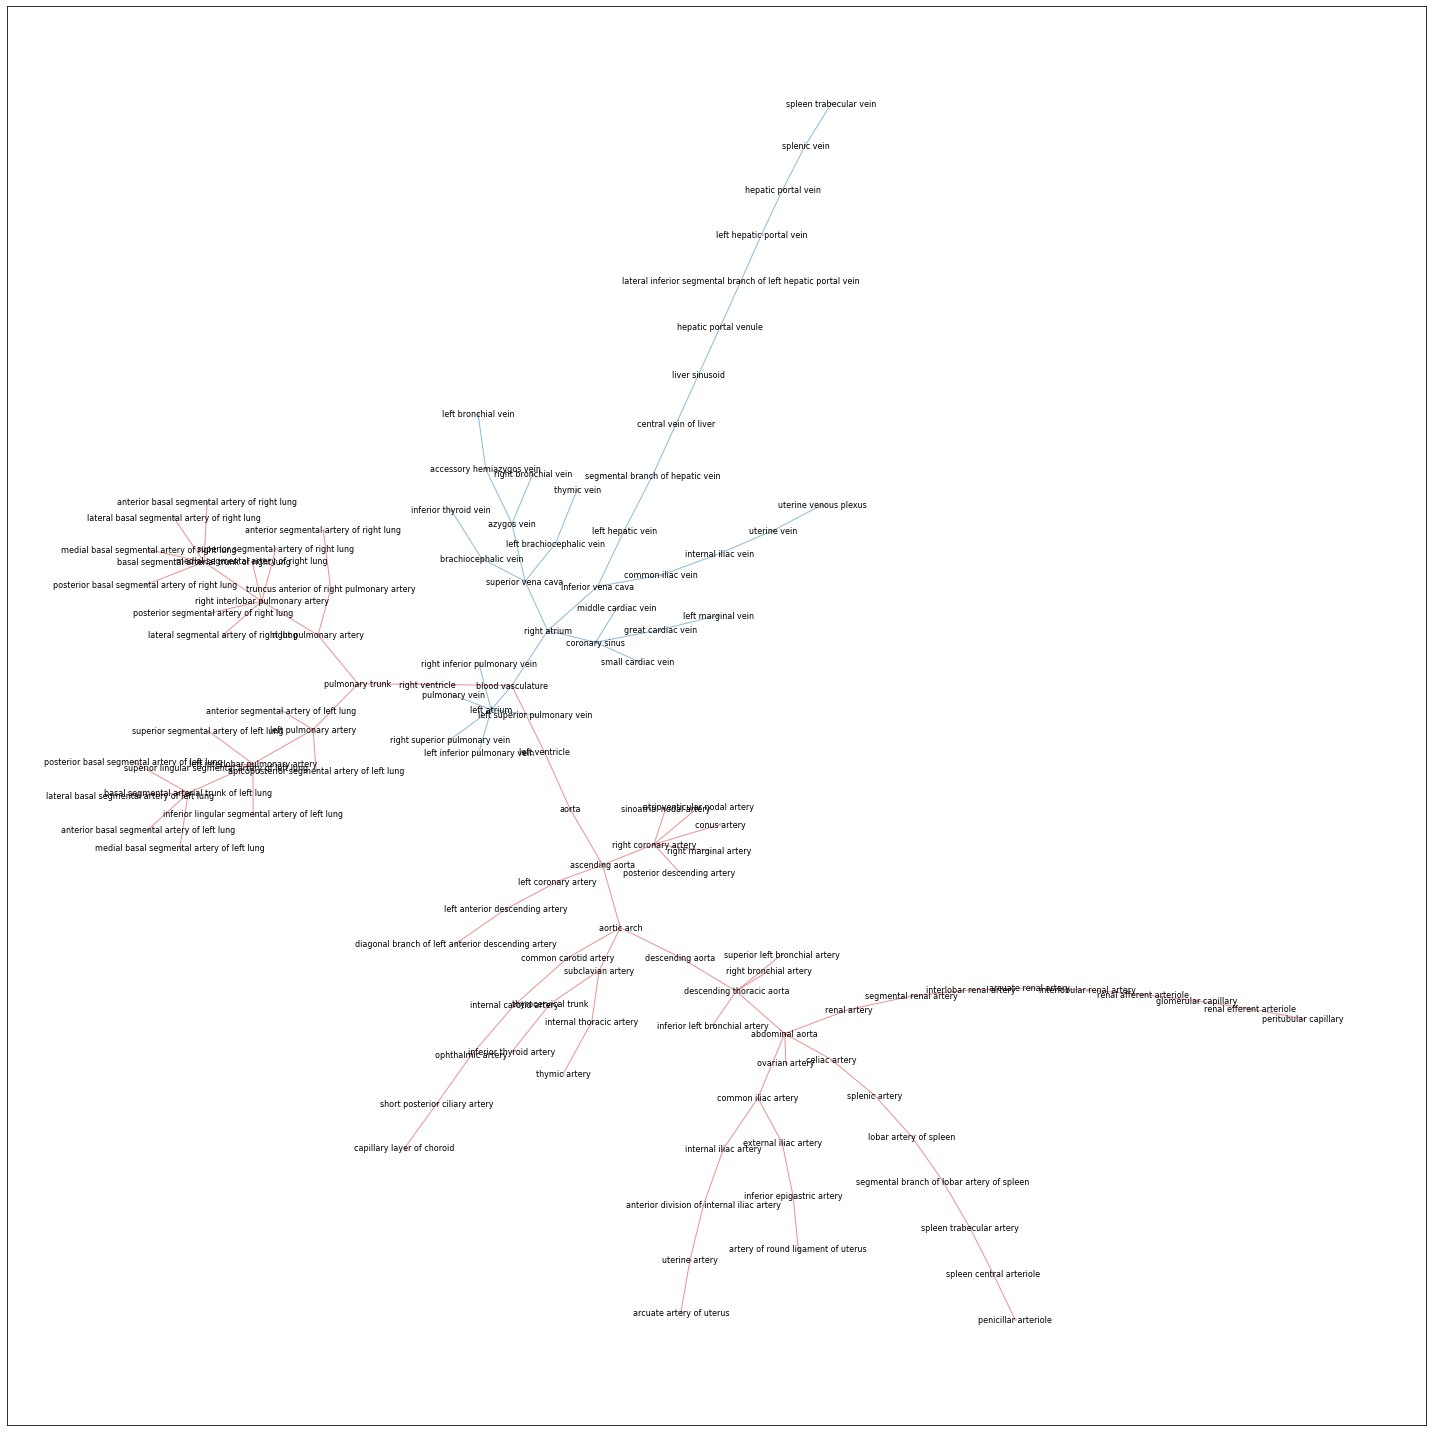

In [995]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(pruned_vasc_graph_comp, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(pruned_vasc_graph_comp, pos=pos, font_size=8)
# nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, veins), pos=pos, alpha=0.5, edge_color='tab:blue')
nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, arteries), pos=pos, alpha=0.5, edge_color='tab:red')

plt.tight_layout()
# plt.savefig('completed_vascular.png', dpi=350)
plt.show()

# Female and male vascular network 

In [1083]:
vasc_data.BodyPart.unique()

array(['abdominal cavity', 'abdominal cavity;thoracic cavity',
       'abdominal wall', 'adrenal gland', 'arm', 'brain', 'brainstem',
       'cerebellum', 'clitoris', 'diaphragm', 'ear', 'esophagus', 'eye',
       'face', 'foot', 'hand', 'head', 'heart', 'heart chamber', 'kidney',
       'large intestine', 'larynx', 'leg', 'liver', 'lung', 'neck',
       'nose', 'ovary', 'pancreas', 'pancreas;small intestine', 'pelvis',
       'penis', 'pituitary gland', 'rectum', 'scrotum', 'shoulder',
       'small intestine', 'spinal cord', 'spleen', 'stomach',
       'stomach;small intestine', 'testis', 'thoracic cavity',
       'thoracic wall', 'thymus', 'thyroid gland', 'urinary bladder',
       'uterus', 'vagina'], dtype=object)

In [1084]:
female_vessels = vasc_data[vasc_data.BodyPart.isin(['clitoris', 'ovary', 'uterus', 'vagina'])]

In [1085]:
male_vessels = vasc_data[vasc_data.BodyPart.isin(['penis', 'scrotum', 'testis'])]

In [1090]:
pruned_vasc_graph_comp_male = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in female_vessels.Vessel.values])

In [1091]:
pruned_vasc_graph_comp_female = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in male_vessels.Vessel.values])

In [1092]:
len(pruned_vasc_graph_comp_male)

112

In [1093]:
len(pruned_vasc_graph_comp_female)

118

In [1094]:
len(pruned_vasc_graph_comp)

118

In [1065]:
def plot_fixed_graph2(graph, viz=female_viz, bundle_edges=False, draw_labels=False, filename='vasculature'):
    graphs = {'veins': nx.induced_subgraph(graph, veins), 'arteries': nx.induced_subgraph(graph, arteries)}
    coords = {'veins': get_coordinates_4_vessels(viz, graphs['veins']), 'arteries': get_coordinates_4_vessels(viz, graphs['arteries'])}
    relabel_mapping_inv = {'veins': coords['veins']['name_in_vasc'].to_dict(), 'arteries': coords['arteries']['name_in_vasc'].to_dict()}
    relabel_mapping =  {'veins': {v: k for k, v in relabel_mapping_inv['veins'].items()}, 'arteries':{v: k for k, v in relabel_mapping_inv['arteries'].items()}}
    # {'veins': , 'arteries': }
    renamed_comp = {'veins': nx.relabel_nodes(graphs['veins'], relabel_mapping['veins']), 'arteries': nx.relabel_nodes(graphs['arteries'], relabel_mapping['arteries']) } 
    
    pos = {'veins': coords['veins']['coords'].dropna().to_dict(), 'arteries': coords['arteries']['coords'].dropna().to_dict()}
    pos['veins'][relabel_mapping['veins']['blood vasculature']] = np.array([850, -860])
    pos['arteries'][relabel_mapping['arteries']['blood vasculature']] = np.array([850, -860])
    pos2 = {'veins': nx.spring_layout(renamed_comp['veins'], pos=pos['veins'], fixed=list(pos['veins'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['veins']))), 
            'arteries': nx.spring_layout(renamed_comp['arteries'], pos=pos['arteries'], fixed=list(pos['arteries'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['arteries'])))}
    
    if not bundle_edges:
        plt.figure(figsize=(20,20))
        plt.axes().set_aspect('equal')
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        nx.draw(renamed_comp['veins'], pos2['veins'], node_size=10, edge_color='tab:blue', node_color='tab:blue')
        nx.draw(renamed_comp['arteries'], pos2['arteries'], node_size=10, edge_color='tab:red', node_color='tab:red')
        if draw_labels:
            nx.draw_networkx_labels(renamed_comp['veins'], pos2['veins'], labels=relabel_mapping_inv['veins'], font_size=3)
            nx.draw_networkx_labels(renamed_comp['arteries'], pos2['arteries'], labels=relabel_mapping_inv['arteries'], font_size=3)
        # nx.draw_networkx_nodes(renamed_comp, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'{filename}.svg',  transparent=True)
        plt.show()
    else:
        nodes_only = {'veins': pd.DataFrame.from_dict(relabel_mapping_inv['veins'], orient='index').rename(columns={0:'name'}), 
                      'arteries': pd.DataFrame.from_dict(relabel_mapping_inv['arteries'], orient='index').rename(columns={0:'name'})}
        
        nodes = {'veins': pd.DataFrame.from_dict(pos2['veins']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['veins'])[['name', 'x', 'y']], 
                 'arteries': pd.DataFrame.from_dict(pos2['arteries']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['arteries'])[['name', 'x', 'y']]}
        
        edges = {'veins': nx.to_pandas_edgelist(renamed_comp['veins'])[['source', 'target']], 
                 'arteries': nx.to_pandas_edgelist(renamed_comp['arteries'])[['source', 'target']]}
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        hb = {'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000), 
              'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)}
        
        plt.figure(figsize=(20,20))
        plt.axes().set_aspect('equal')
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)        
        plt.plot(hb['veins']['x'], hb['veins']['y'], color='tab:blue', alpha=0.8)
        plt.plot(hb['arteries']['x'], hb['arteries']['y'], color='tab:red', alpha=0.8)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'{filename}_bundled.svg', pad_inches=0.0)
        plt.show()

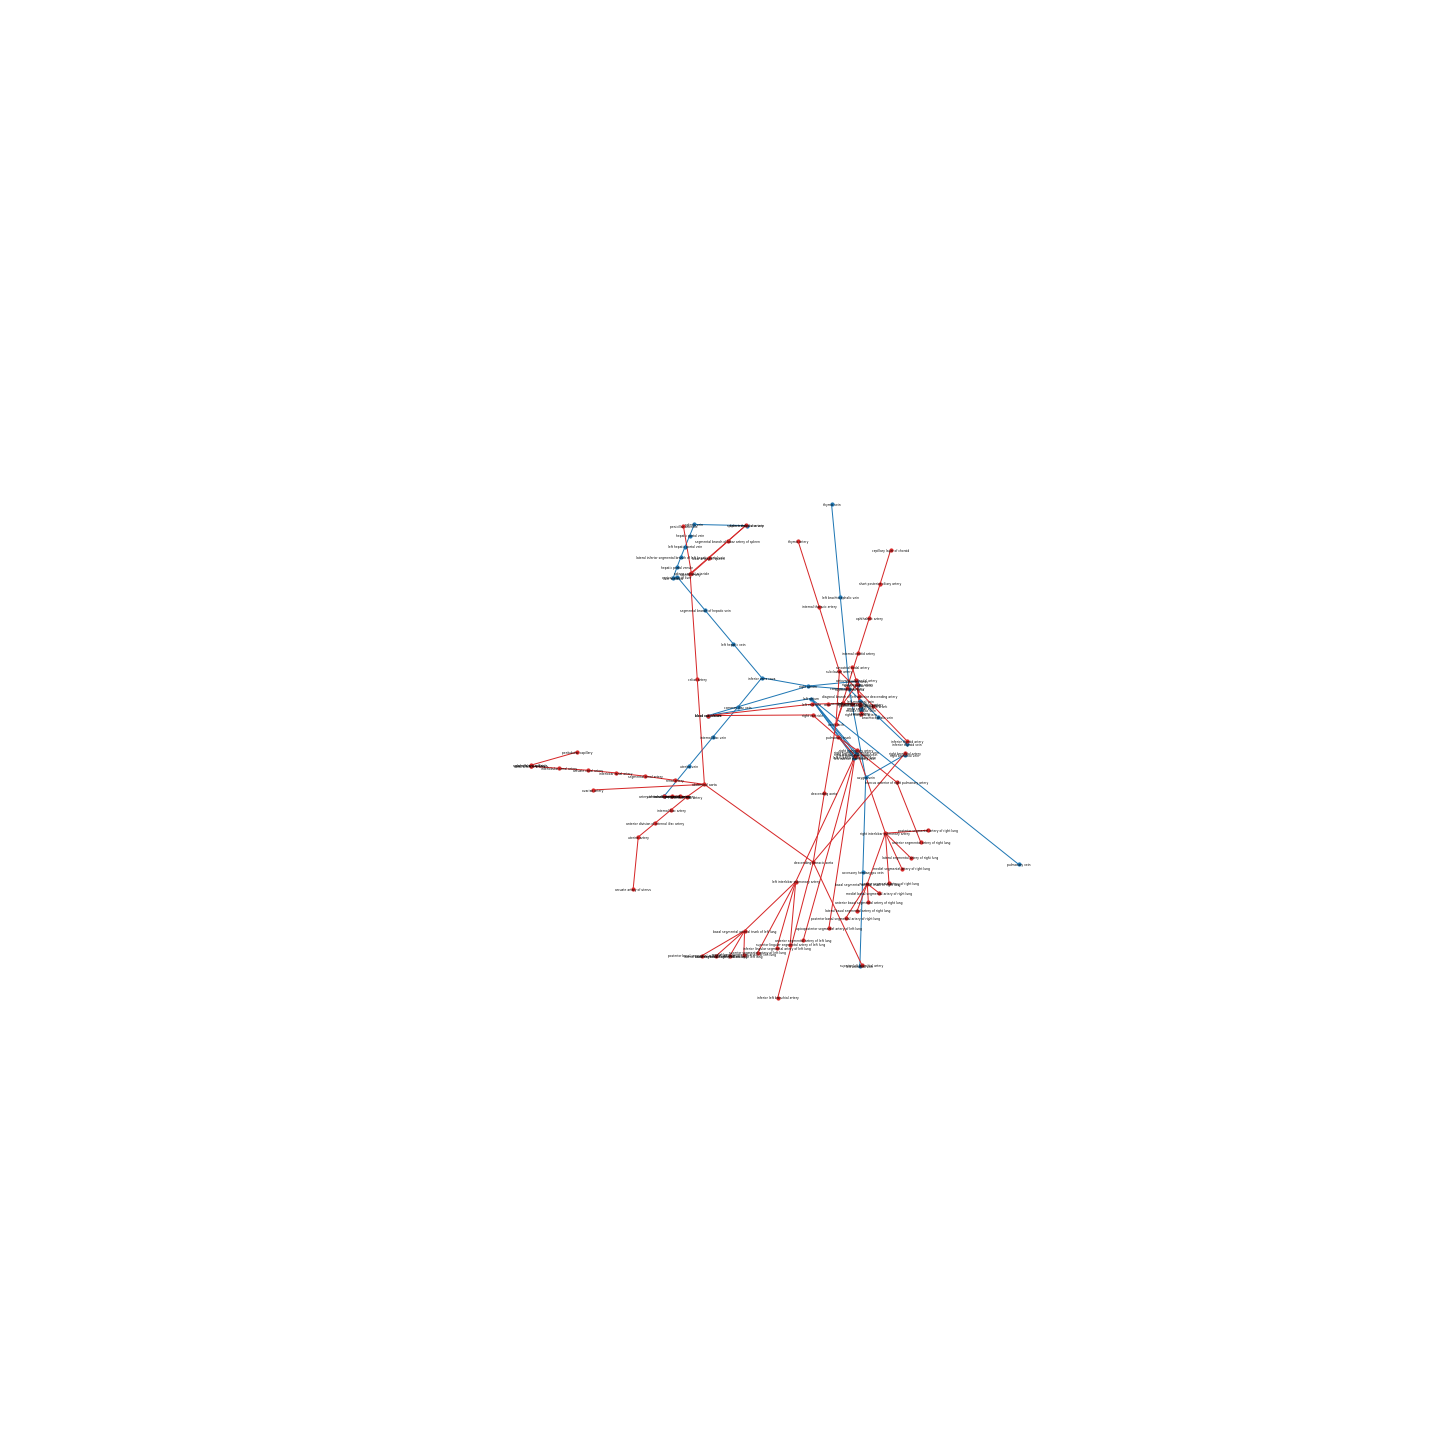

In [1054]:
plot_fixed_graph2(pruned_vasc_graph_comp, draw_labels=True)

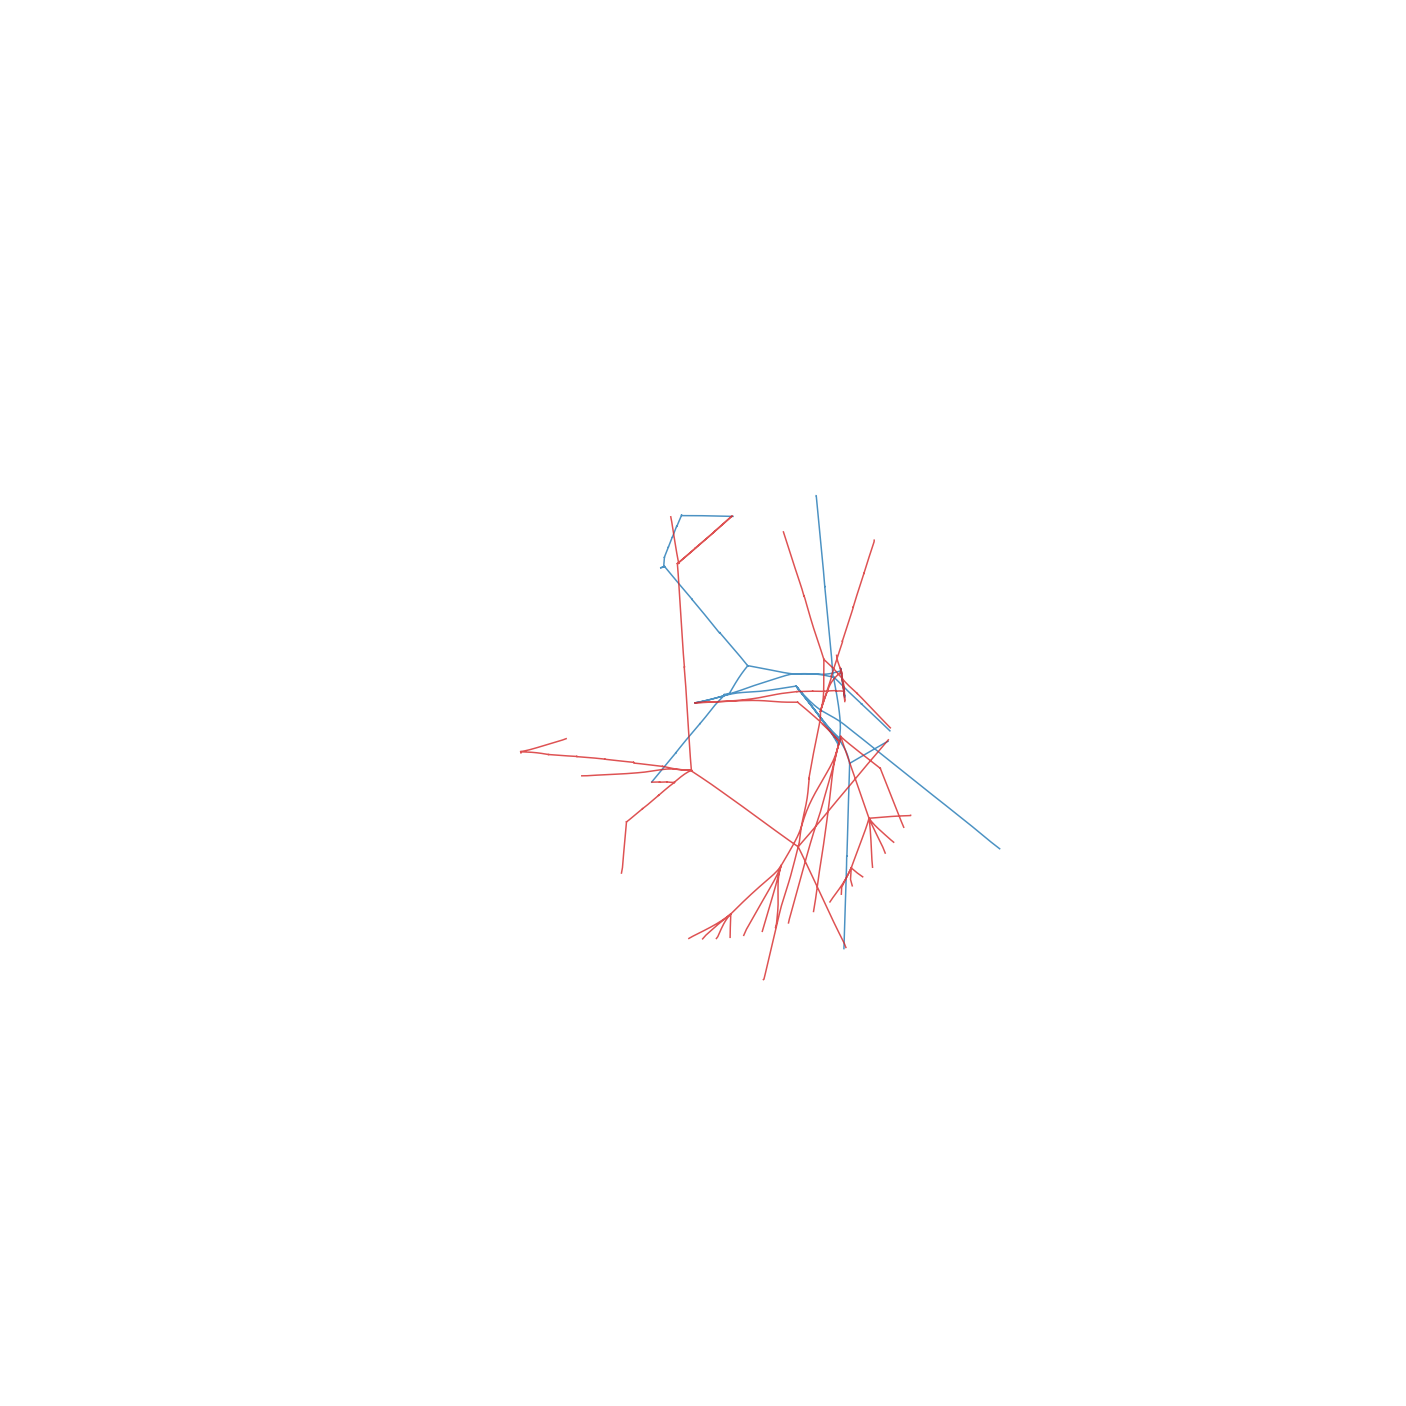

In [1055]:
plot_fixed_graph2(pruned_vasc_graph_comp, bundle_edges=True)

In [1099]:
with open('female_wing.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [1100]:
female_wing_viz = viz['data'][0]['values']

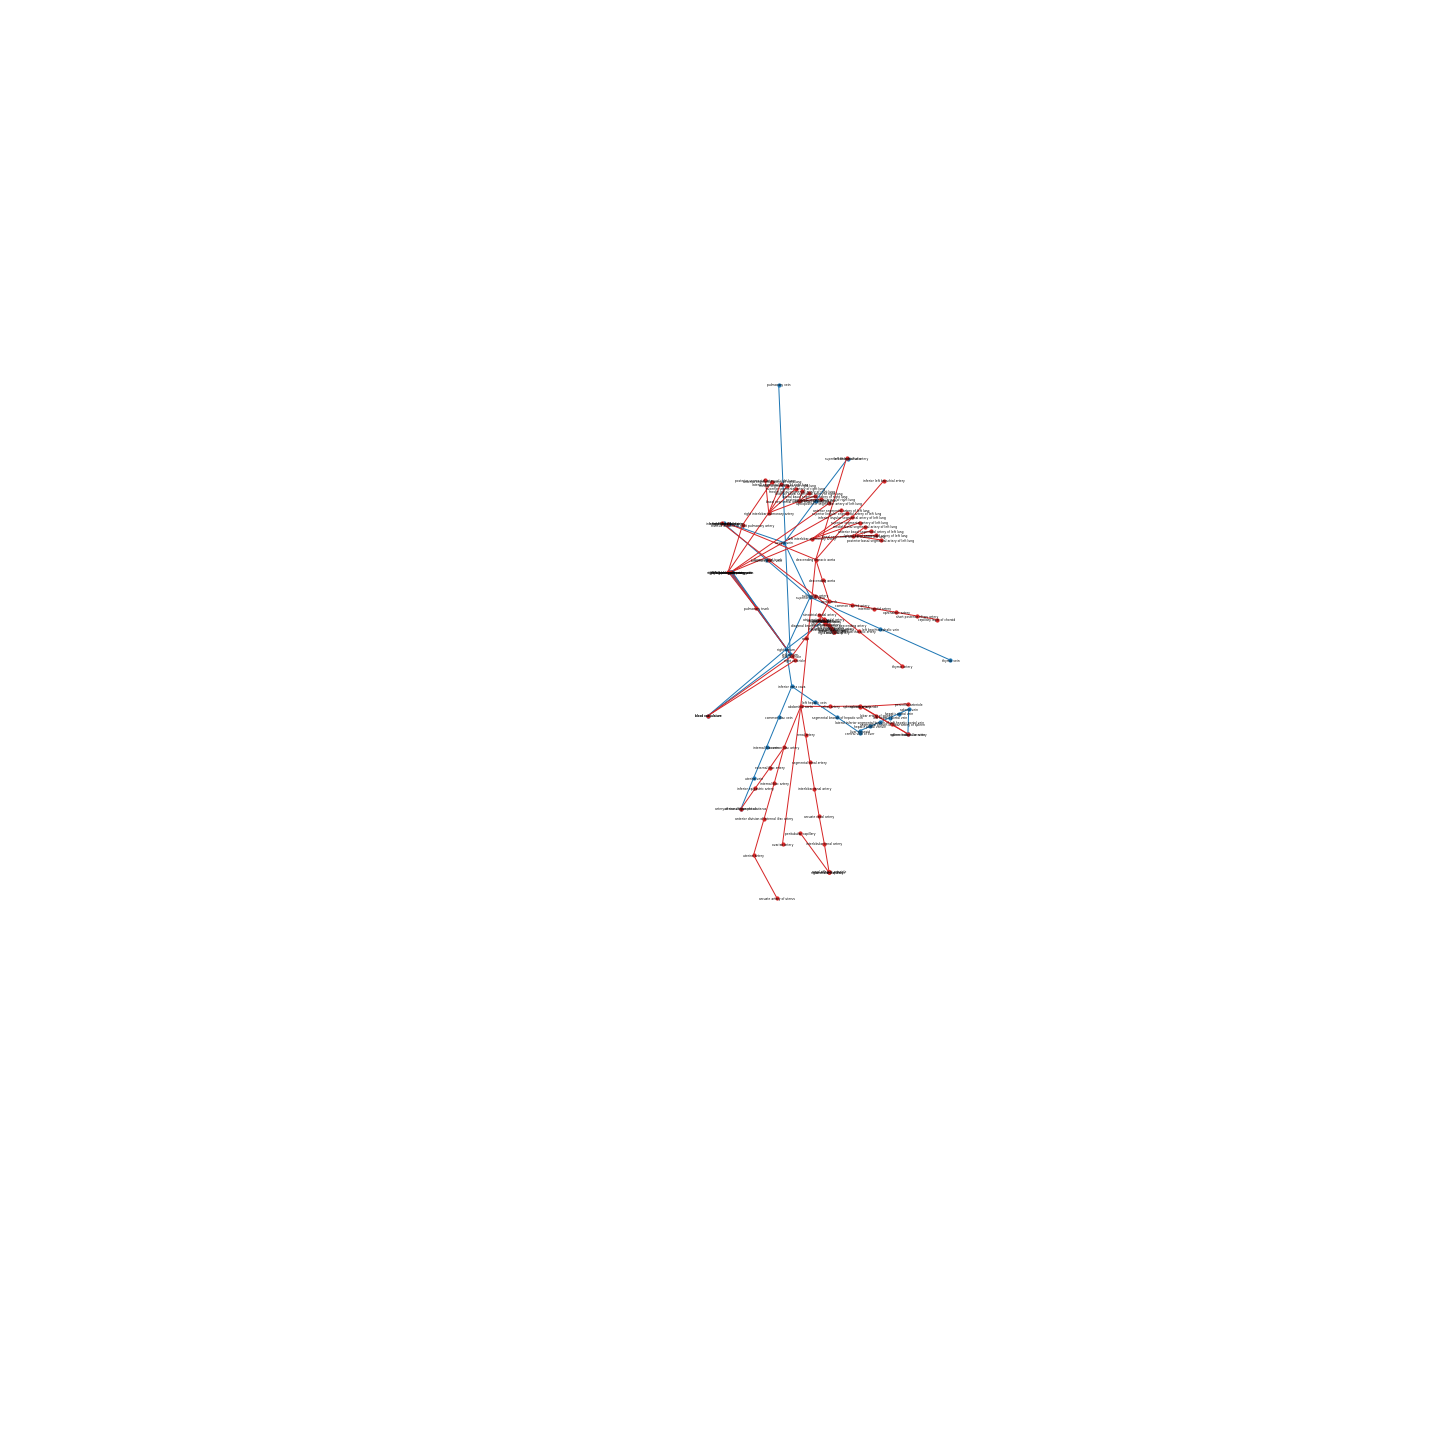

In [1101]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, draw_labels=True, filename='female_wing')

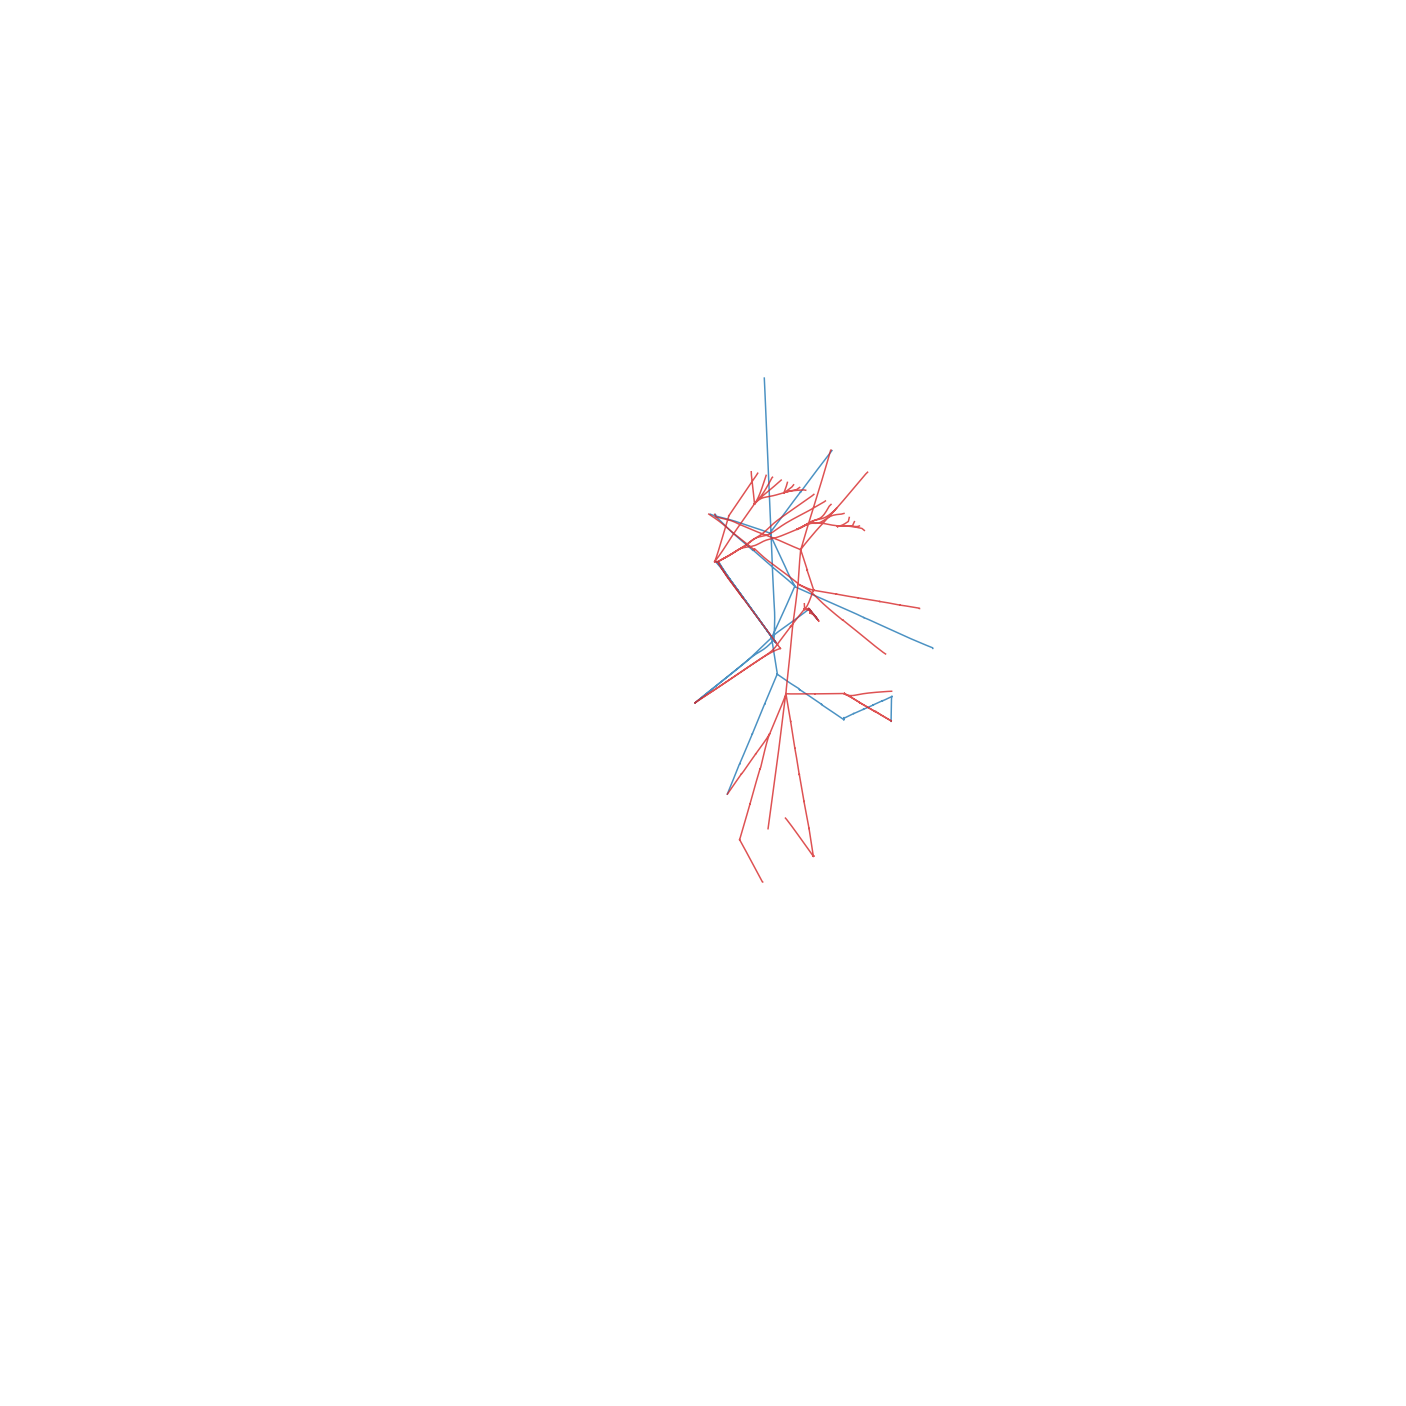

In [1102]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, bundle_edges=True, filename='female_wing')

In [1103]:
with open('male_wing.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [1104]:
male_wing_viz = viz['data'][0]['values']

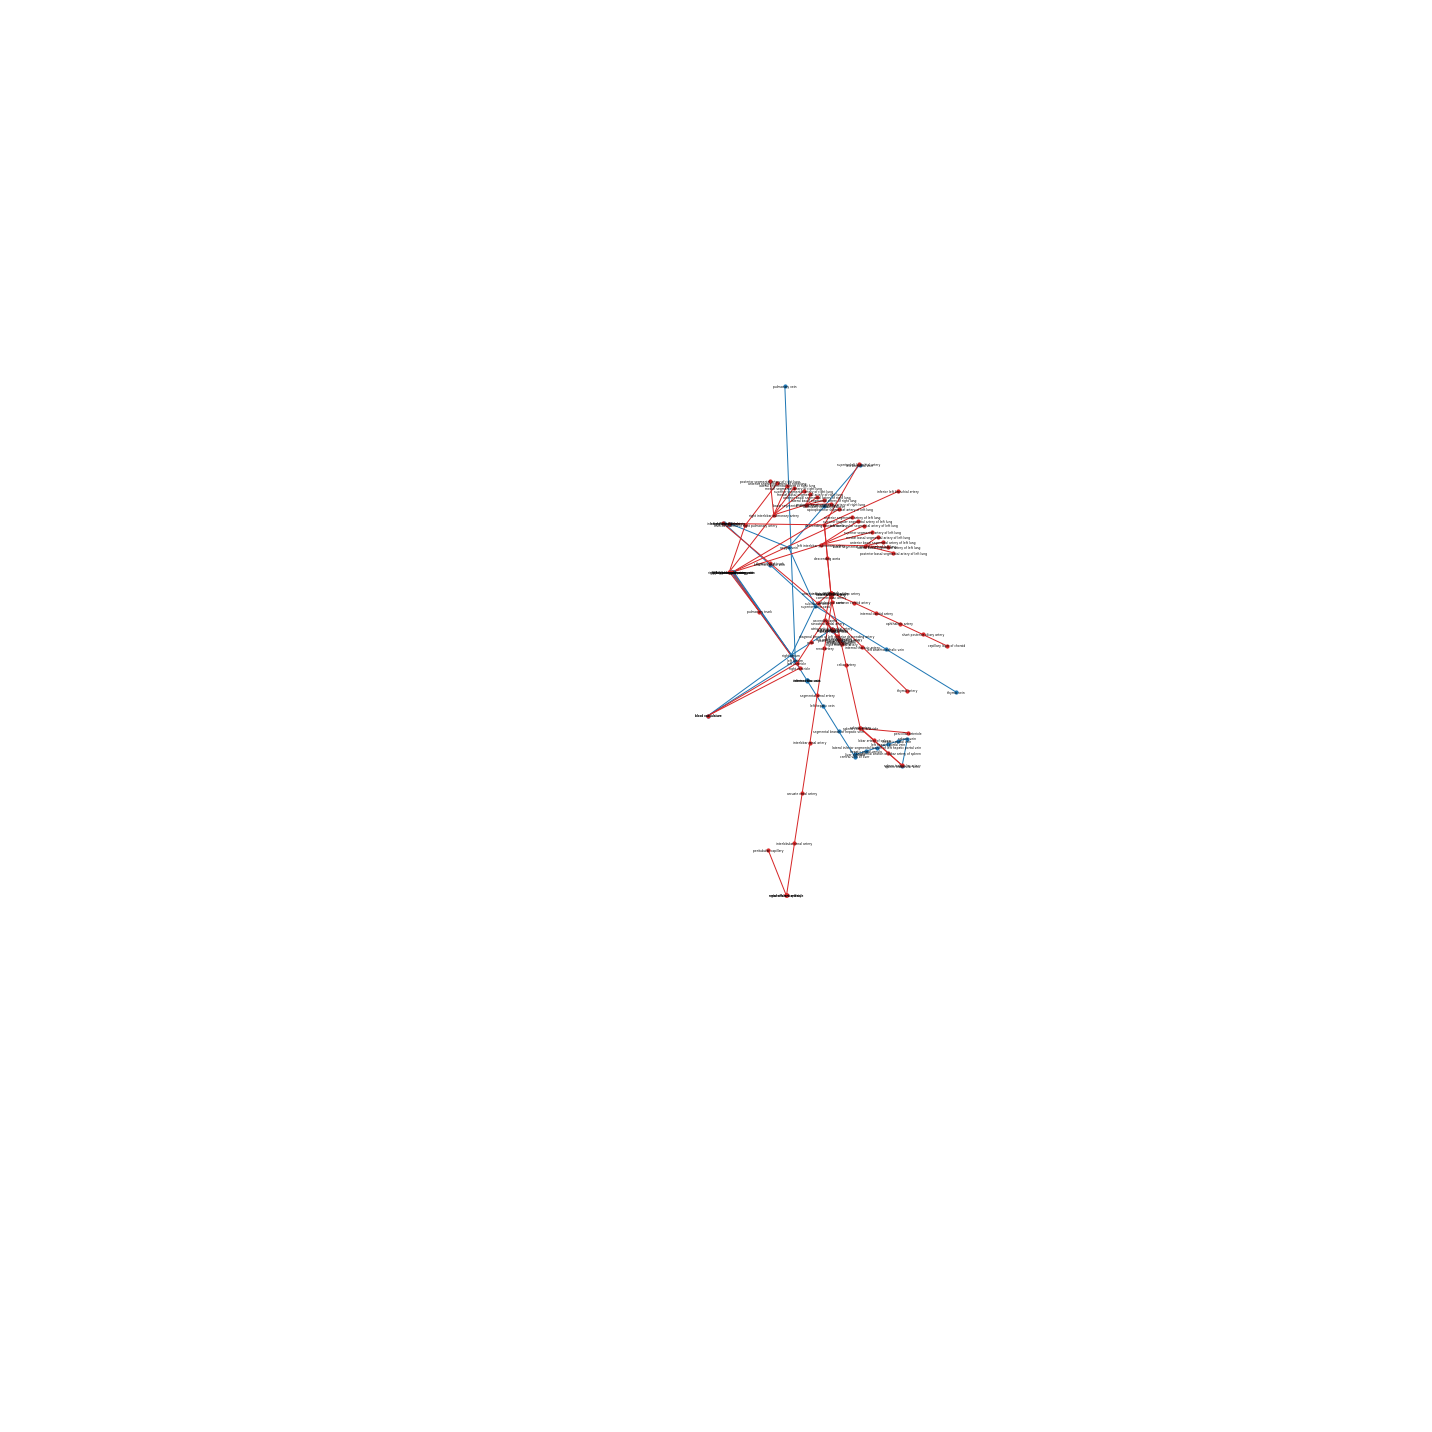

In [1105]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, draw_labels=True, filename='male_wing')

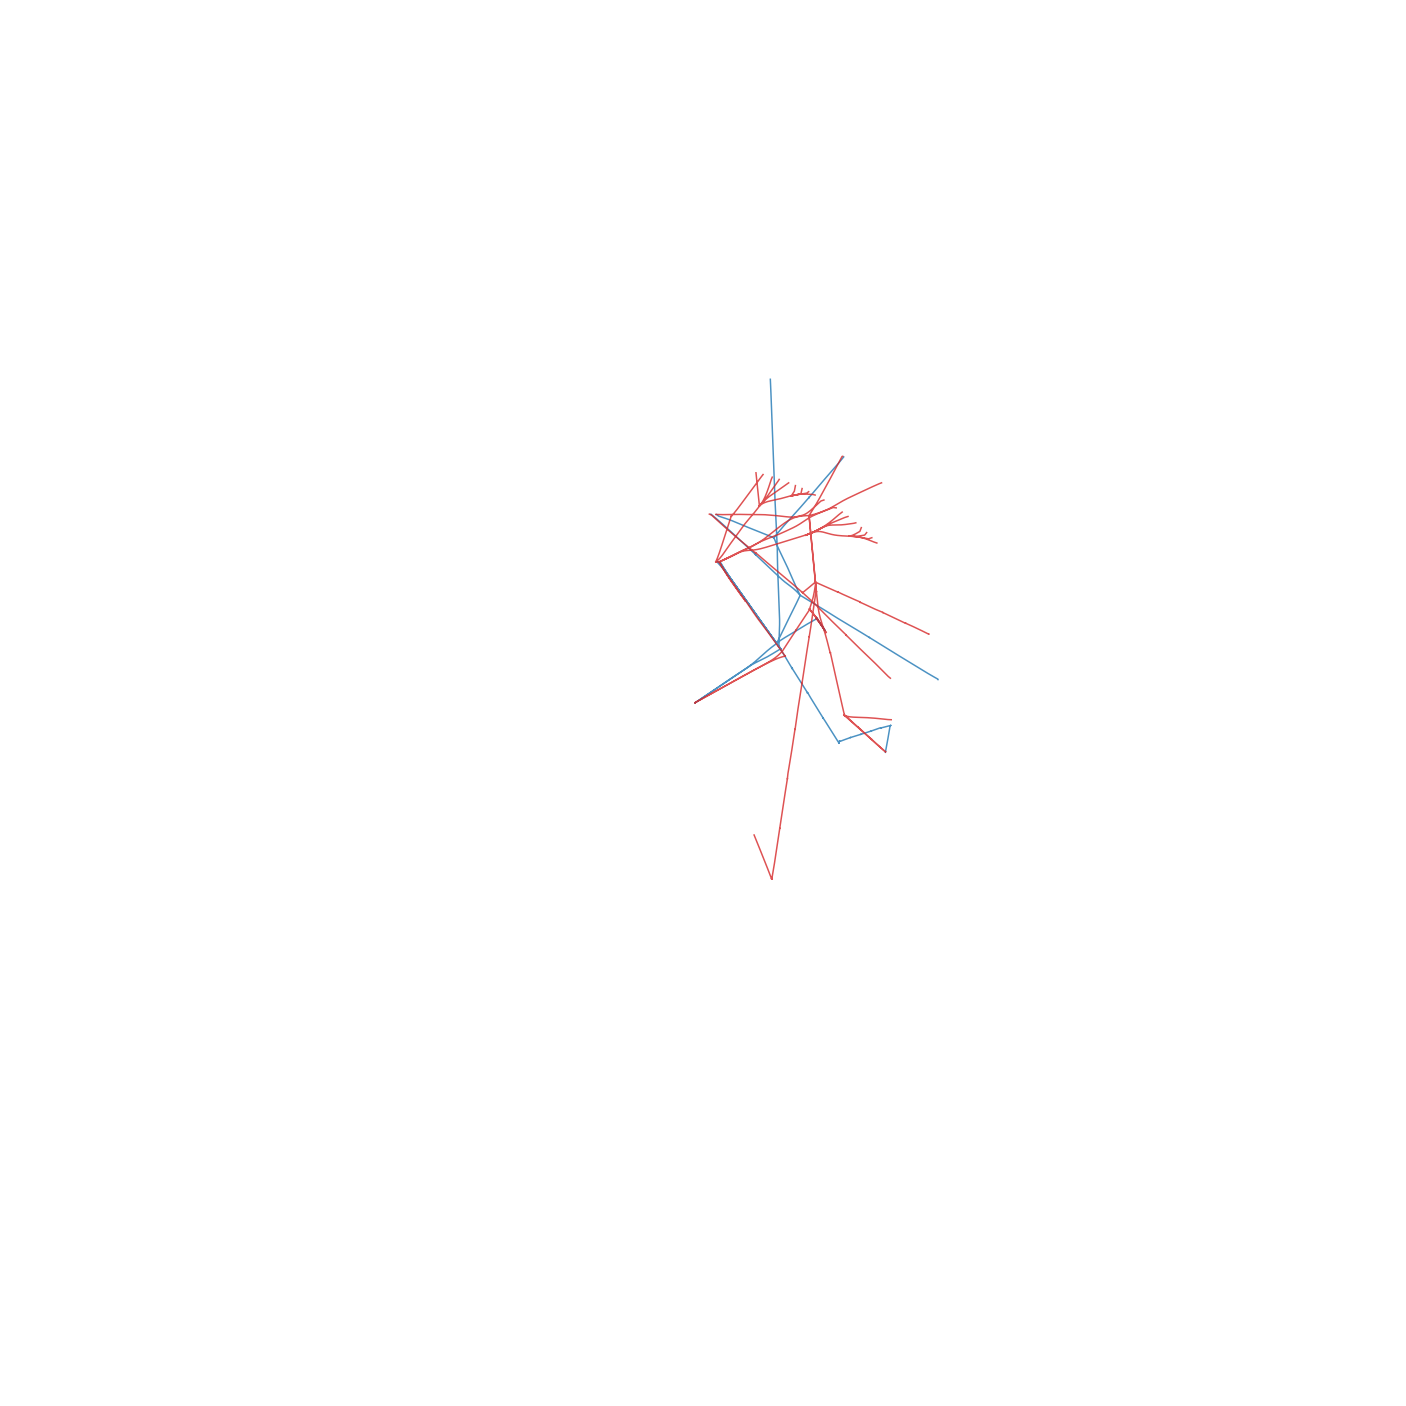

In [1106]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, bundle_edges=True, filename='male_wing')